#### GPU Testing


In [5]:
import tensorflow as tf

def test_tensorflow():
    print("TensorFlow version:", tf.__version__)
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    for gpu in tf.config.experimental.list_physical_devices('GPU'):
        print(gpu)

if __name__ == "__main__":
    test_tensorflow()

TensorFlow version: 2.10.0
Num GPUs Available:  2
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [2]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TF version: 2.10.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [1]:
import torch
print("Torch:", torch.__version__)
print("CUDA:", torch.version.cuda)
print("GPU available:", torch.cuda.is_available())


Torch: 1.12.1+cu113
CUDA: 11.3
GPU available: True


#### Imports and paths



In [ ]:
OriginalData=r'D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\imageTr'
LabelsofData=r'D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr'
PreprocessedData=r'D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_Harp_Preprocessed'
AdniHarp=r'D:\Faizaan\1_DATA_PROJECTS\Data\ADNI\HARP\HarP\ADNI'

#### MODEL summary and reusable funtions

In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet3DDropoutResiduals(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, base_channels=32, dropout_rate=0.2):
        super(UNet3DDropoutResiduals, self).__init__()

        # Encoder layers with dropout and residual connections
        self.encoder_blocks = nn.ModuleList([
            self.conv_block(in_channels, base_channels, dropout_rate),  # Block 1
            self.conv_block(base_channels, base_channels * 2, dropout_rate),  # Block 2
            self.conv_block(base_channels * 2, base_channels * 4, dropout_rate),  # Block 3
            self.conv_block(base_channels * 4, base_channels * 8, dropout_rate),  # Block 4
            self.conv_block(base_channels * 8, base_channels * 16, dropout_rate)  # Block 5 (bottleneck)
        ])

        # Pooling layers
        self.pool = nn.MaxPool3d(kernel_size=2)

        # Decoder layers with ConvTranspose3d for upsampling
        self.decoder_blocks = nn.ModuleList([
            self.upconv_block(base_channels * 16, base_channels * 8),  # Decoder Block 1
            self.upconv_block(base_channels * 8, base_channels * 4),  # Decoder Block 2
            self.upconv_block(base_channels * 4, base_channels * 2),  # Decoder Block 3
            self.upconv_block(base_channels * 2, base_channels),  # Decoder Block 4
        ])

        # Convolutions after concatenation to reduce the number of channels with dropout and residual connections
        self.conv_after_concat = nn.ModuleList([
            self.conv_block(base_channels * 16, base_channels * 8, dropout_rate),  # After concat in Decoder Block 1
            self.conv_block(base_channels * 8, base_channels * 4, dropout_rate),   # After concat in Decoder Block 2
            self.conv_block(base_channels * 4, base_channels * 2, dropout_rate),   # After concat in Decoder Block 3
            self.conv_block(base_channels * 2, base_channels, dropout_rate),       # After concat in Decoder Block 4
        ])

        # Final output layer
        self.final_conv = nn.Conv3d(base_channels, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels, dropout_rate=0.1):
        # The convolutional block includes residual connections
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_channels),  # Instance Normalization
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout_rate),  # Dropout layer
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_channels),  # Instance Normalization
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout_rate)  # Dropout layer
        )

    def forward_conv_block(self, x, block):
        # Apply the convolutional block and add residual connection
        out = block(x)
        if x.size() == out.size():
            out = out + x  # Residual connection: input added to output
        return out

    def upconv_block(self, in_channels, out_channels):
        return nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder path with skip connections and residuals
        skip_connections = []
        for enc_block in self.encoder_blocks:
            x = self.forward_conv_block(x, enc_block)
            skip_connections.append(x)
            x = self.pool(x)
        x = skip_connections.pop()
        for i, dec_block in enumerate(self.decoder_blocks):
            skip = skip_connections.pop()

            # Upsample and concatenate with the skip connection
            x = dec_block(x)

            # Ensure the spatial dimensions match (padding if needed)
            x = self.pad_if_needed(x, skip)

            # Concatenate along the channel dimension
            x = torch.cat((x, skip), dim=1)

            # Pass through the convolution block (with residual connection) to reduce channels after concatenation
            x = self.forward_conv_block(x, self.conv_after_concat[i])

        # Final convolution to reduce to desired output channels
        x = self.final_conv(x)
        return x

    def pad_if_needed(self, x, skip):
        # Automatically pad the smaller tensor so it matches the spatial dimensions of the larger one
        diff_depth = skip.size(2) - x.size(2)
        diff_height = skip.size(3) - x.size(3)
        diff_width = skip.size(4) - x.size(4)

        x = F.pad(x, [diff_width // 2, diff_width - diff_width // 2,
                      diff_height // 2, diff_height - diff_height // 2,
                      diff_depth // 2, diff_depth - diff_depth // 2])
        return x

# Instantiate the model
modelUNet3DDropoutResiduals_V2_sample = UNet3DDropoutResiduals(in_channels=1, out_channels=1)
from torchsummary import summary
modelUNet3DDropoutResiduals_V2_sample = modelUNet3DDropoutResiduals_V2_sample.cuda()
summary(modelUNet3DDropoutResiduals_V2_sample,
        input_size=(1, 64, 64, 96),
        device='cuda')



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 64, 64, 96]             896
    InstanceNorm3d-2       [-1, 32, 64, 64, 96]               0
              ReLU-3       [-1, 32, 64, 64, 96]               0
         Dropout3d-4       [-1, 32, 64, 64, 96]               0
            Conv3d-5       [-1, 32, 64, 64, 96]          27,680
    InstanceNorm3d-6       [-1, 32, 64, 64, 96]               0
              ReLU-7       [-1, 32, 64, 64, 96]               0
         Dropout3d-8       [-1, 32, 64, 64, 96]               0
         MaxPool3d-9       [-1, 32, 32, 32, 48]               0
           Conv3d-10       [-1, 64, 32, 32, 48]          55,360
   InstanceNorm3d-11       [-1, 64, 32, 32, 48]               0
             ReLU-12       [-1, 64, 32, 32, 48]               0
        Dropout3d-13       [-1, 64, 32, 32, 48]               0
           Conv3d-14       [-1, 64, 32,

In [27]:
import torch
import time
import torch.nn.functional as F
from torchsummary import summary

# 1) Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 2) Instantiate and move model
model = UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)
model.eval()  # disable dropout, etc.

# 3) Print model summary
#    summary wants input_size=(C, D, H, W) when using 3D
# summary(model, input_size=(1, 64, 64, 96), device=str(device))

# 4) Count parameters & estimate memory
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
memory_mb    = total_params * 4 / (1024**2)  # float32 = 4 bytes
print(f"\nTotal trainable parameters: {total_params:,}")
print(f"Approx. parameter memory: {memory_mb:.2f} MB")

# 5) Benchmark inference time
batch_size  = 1
dummy_input = torch.randn(batch_size, 1, 64, 64, 96, device=device)

# Warm-up
for _ in range(10):
    _ = model(dummy_input)
    if device.type == 'cuda':
        torch.cuda.synchronize()

# Timed runs
n_runs = 100
start  = time.time()
for _ in range(n_runs):
    _ = model(dummy_input)
    if device.type == 'cuda':
        torch.cuda.synchronize()
end    = time.time()

avg_time = (end - start) / n_runs
print(f"\nAverage inference time (batch size {batch_size}): {avg_time*1000:.2f} ms per volume")


Using device: cuda

Total trainable parameters: 22,575,329
Approx. parameter memory: 86.12 MB

Average inference time (batch size 1): 72.54 ms per volume


##### Resusable funtions

In [28]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff
import torch
from skimage import measure
from scipy.ndimage import morphology

# Function to calculate OSR (Overlap-to-Signal Ratio)
# def overlap_signal_ratio(y_true, y_pred, smooth=1):
#     y_pred_labels = (y_pred >= 0.5).float()
#     intersection = torch.sum(y_true * y_pred_labels)
#     signal = torch.sum(y_true)
#     osr = (intersection + smooth) / (signal + smooth)
#     return osr

# Function to calculate USR (Under-Segmentation Rate)
def under_segmentation_rate(y_true, y_pred, smooth=1):
    y_pred_labels = (y_pred >= 0.5).float()
    y_true_labels = (y_true >= 0.5).float()
    false_neg = torch.sum(y_true_labels * (1 - y_pred_labels))
    true_pos = torch.sum(y_true_labels * y_pred_labels)
    ground_truth_area = torch.sum(y_true_labels)
    prediction_area = torch.sum(y_pred_labels)
    usr = (false_neg + smooth) / (ground_truth_area + prediction_area + smooth)
    return usr

# Function to calculate ASD (Average Surface Distance)

import torch.nn.functional as F

def bce_loss(y_true, y_pred):
    # Ensure y_true and y_pred have the same shape
    return F.binary_cross_entropy(y_pred, y_true)

# Function to calculate ASD (Average Surface Distance)
def over_segmentation_ratio(y_true, y_pred, smooth=1e-5):
    y_pred_labels = (y_pred >= 0.5).float()
    y_true_labels = (y_true >= 0.5).float()
    false_positives = torch.sum((y_pred_labels == 1) & (y_true_labels == 0))
    ground_truth_area = torch.sum(y_true_labels)
    prediction_area = torch.sum(y_pred_labels)
    osr = (false_positives + smooth) / (ground_truth_area + prediction_area + smooth)
    return osr


import numpy as np
from scipy.ndimage import morphology

def average_surface_distance(y_true, y_pred, spacing=None):
    """
    Computes the Average Surface Distance (ASD) between the predicted and true binary masks.
    
    Parameters:
    - y_true (torch.Tensor): Ground truth binary mask.
    - y_pred (torch.Tensor): Predicted binary mask.
    - spacing (tuple or list): Voxel spacing for each dimension (optional). This accounts for anisotropic voxel sizes.
    
    Returns:
    - float: Average Surface Distance (ASD) between the surfaces of the ground truth and predicted masks.
    """
    
    # Convert tensors to numpy arrays and ensure boolean type
    y_true_np = y_true.detach().cpu().numpy().astype(np.bool_)
    y_pred_np = y_pred.detach().cpu().numpy().astype(np.bool_)
    
    # Define connectivity for finding surface voxels
    conn = morphology.generate_binary_structure(y_true_np.ndim, 1)
    
    # Surface voxels: Logical XOR between the binary mask and its eroded version
    true_surface = np.logical_xor(y_true_np, morphology.binary_erosion(y_true_np, conn))
    pred_surface = np.logical_xor(y_pred_np, morphology.binary_erosion(y_pred_np, conn))
    
    # Check for empty surfaces (in case of no object in the segmentation)
    if np.sum(true_surface) == 0 or np.sum(pred_surface) == 0:
        return float('inf')
    
    # Compute the Euclidean distance transform from the surface
    true_distances = morphology.distance_transform_edt(~true_surface, sampling=spacing)
    pred_distances = morphology.distance_transform_edt(~pred_surface, sampling=spacing)
    
    # Measure distances from one surface to the other
    dist_pred_to_true = np.mean(true_distances[pred_surface != 0])
    dist_true_to_pred = np.mean(pred_distances[true_surface != 0])
    
    # Calculate ASD as the mean of the two distances
    asd = (dist_pred_to_true + dist_true_to_pred) / 2.0
    
    return asd


# Function to calculate HD (Hausdorff Distance)
def hausdorff_distance(y_true, y_pred):
    y_true_labels = (y_true >= 0.5).cpu().numpy().astype(np.bool_)  # Use np.bool_ instead of np.bool
    y_pred_labels = (y_pred >= 0.5).cpu().numpy().astype(np.bool_)

    distances = []
    for slice_idx in range(y_true_labels.shape[0]):
        true_slice = y_true_labels[slice_idx, :, :]
        pred_slice = y_pred_labels[slice_idx, :, :]

        if np.sum(true_slice) == 0 or np.sum(pred_slice) == 0:
            continue

        true_surface_points = np.argwhere(true_slice)
        pred_surface_points = np.argwhere(pred_slice)

        hd_forward = directed_hausdorff(true_surface_points, pred_surface_points)[0]
        hd_backward = directed_hausdorff(pred_surface_points, true_surface_points)[0]

        distances.append(max(hd_forward, hd_backward))

    return np.mean(distances) if distances else float('inf')

def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1):
    true_pos = torch.sum(y_true * y_pred)
    false_neg = torch.sum(y_true * (1 - y_pred))
    false_pos = torch.sum((1 - y_true) * y_pred)
    tversky = (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)
    return 1 - tversky

# Combined loss: Binary Cross-Entropy + Tversky Loss
def combined_loss(y_true, y_pred):
    bce = F.binary_cross_entropy(y_pred, y_true)
    tversky = tversky_loss(y_true, y_pred)
    return 0.9*bce + tversky

# Function to calculate Dice coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_pred_labels = (y_pred >= 0.5).float()
    intersection = torch.sum(y_true * y_pred_labels)
    dice = (2 * intersection + smooth) / (torch.sum(y_true) + torch.sum(y_pred_labels) + smooth)
    return dice

# Function to calculate Jaccard index (IoU)
def jaccard_index(y_true, y_pred, smooth=1):
    y_pred_labels = (y_pred >= 0.5).float()
    intersection = torch.sum(y_true * y_pred_labels)
    union = torch.sum(y_true) + torch.sum(y_pred_labels) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return jaccard

# Function to calculate mean IoU (mIoU)
def mean_iou(y_true, y_pred, smooth=1):
    return jaccard_index(y_true, y_pred, smooth)  # Same as Jaccard for binary

# Function to calculate F1 score
def f1_score(y_true, y_pred, smooth=1):
    y_pred_labels = (y_pred >= 0.5).float()
    true_pos = torch.sum(y_true * y_pred_labels)
    precision = true_pos / (torch.sum(y_pred_labels) + smooth)
    recall = true_pos / (torch.sum(y_true) + smooth)
    f1 = (2 * precision * recall + smooth) / (precision + recall + smooth)
    return f1
def calculate_accuracy(y_true, y_pred):
    y_pred_labels = (y_pred >= 0.5).float()  # Threshold for binary classification (0.5 for sigmoid output)
    correct = (y_pred_labels == y_true).float().sum()  # Count where predictions are correct
    return correct / y_true.numel()  # Return the percentage of correct predictions


#### Data HARP (64x64x96) Demographics

Image shape: (64, 64, 96)
Label shape: (64, 64, 96)
Image voxel range: 169.0 to 6409.0
Label unique values: [0. 1.]


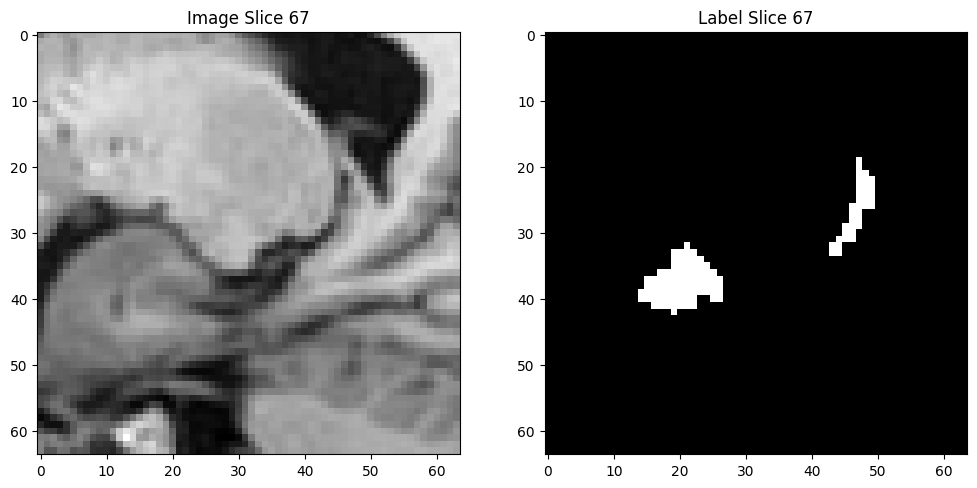

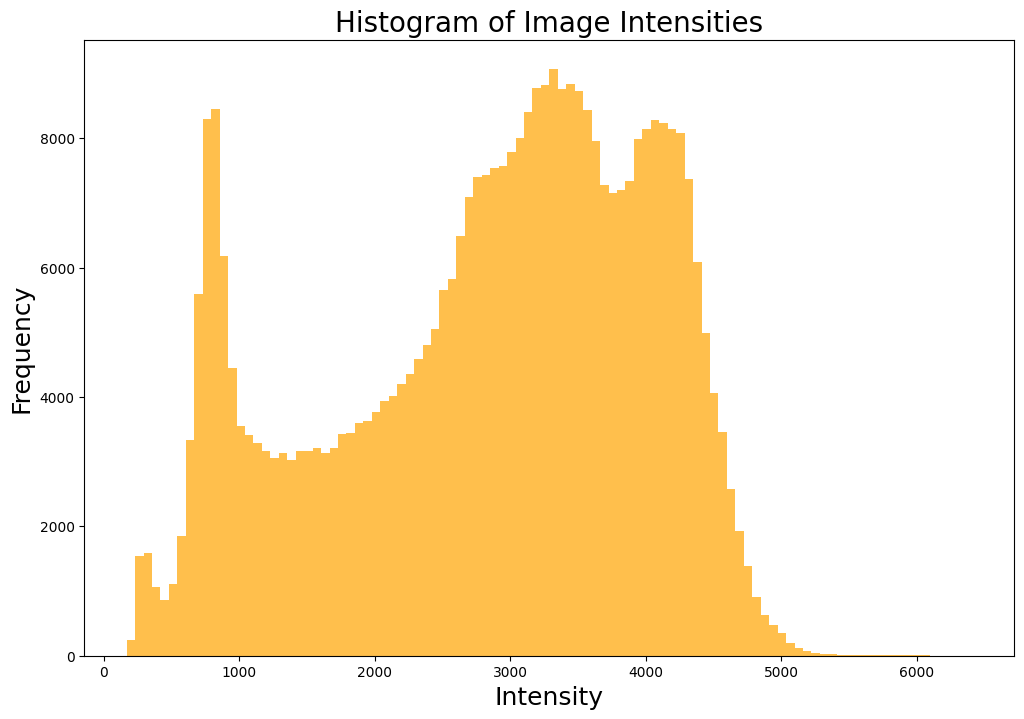

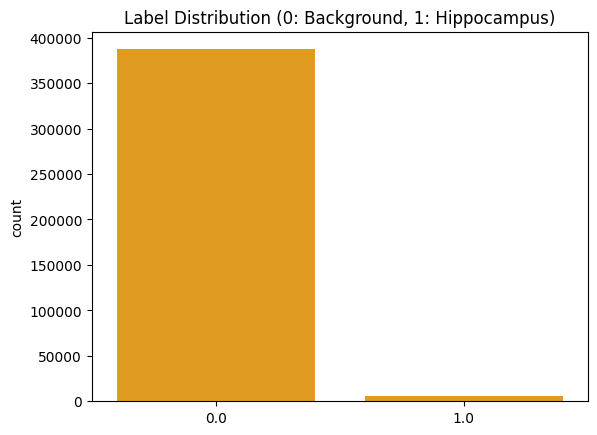

In [95]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Directory Path
directory_path = r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP"

# Function to load and analyze a .nii file
def load_nii_file(file_path):
    img = nib.load(file_path)
    data = img.get_fdata()
    return data, img.header

# Load an example image and label pair
image_file = os.path.join(directory_path, "imageTr", "HarP_000.nii")
label_file = os.path.join(directory_path, "labelTr", "HarP_000.nii")

image_data, image_header = load_nii_file(image_file)
label_data, label_header = load_nii_file(label_file)

# Dataset statistics
def dataset_statistics(image_data, label_data):
    print(f"Image shape: {image_data.shape}")
    print(f"Label shape: {label_data.shape}")
    print(f"Image voxel range: {np.min(image_data)} to {np.max(image_data)}")
    print(f"Label unique values: {np.unique(label_data)}")  # Label should have 0 and 1

# Generate some insights using plots
def generate_insights(image_data, label_data):
    # Plotting a random slice from the image and the label
    slice_idx = image_data.shape[2] // 2  # Taking a middle slice for visualization

    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    
    axs[0].imshow(image_data[:, :, slice_idx + 19], cmap='gray')
    axs[0].set_title(f'Image Slice {slice_idx + 19}')
    
    axs[1].imshow(label_data[:, :, slice_idx + 19], cmap='gray')
    axs[1].set_title(f'Label Slice {slice_idx + 19}')
    
    plt.show()

    # Histogram of image intensities
    plt.figure(figsize=(12, 8))
    plt.hist(image_data.flatten(), bins=100, color='orange', alpha=0.7)
    plt.title('Histogram of Image Intensities',fontsize=20)
    plt.xlabel('Intensity',fontsize=18)
    plt.ylabel('Frequency',fontsize=18)
    plt.show()

    # Histogram of label distribution
    sns.countplot(x=label_data.flatten(),color='orange',stat='count')
    plt.title('Label Distribution (0: Background, 1: Hippocampus)')
    plt.show()

# Running the statistics and visualization functions
dataset_statistics(image_data, label_data)
generate_insights(image_data, label_data)


## ABlations Harp

##### ORIGiNAL DATA NO PREPROCESSING

In [121]:
import nibabel as nib
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Directories for images and labels
images_dir = r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\imageTr"
# images_dir = r'D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_Harp_Preprocessed'
labels_dir = r'D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr'

# Function to load a .nii file
def load_nifti_file(filepath):
    img = nib.load(filepath)
    return img.get_fdata()

# List all image and label files
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.nii')])
label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.nii')])

# Verify that corresponding images and labels have the same names
assert len(image_files) == len(label_files)
for img_file, label_file in zip(image_files, label_files):
    assert img_file == label_file, f"Mismatched file: {img_file} and {label_file}"

# Load the data
images = [load_nifti_file(os.path.join(images_dir, f)) for f in image_files]
labels = [load_nifti_file(os.path.join(labels_dir, f)) for f in label_files]

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize image voxel values (between 0 and 1)
images = (images - np.min(images)) / (np.max(images) - np.min(images))

# Check shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


Images shape: (135, 64, 64, 96)
Labels shape: (135, 64, 64, 96)


In [1]:
# Split into training, validation, and testing sets (80% train, 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")


NameError: name 'train_test_split' is not defined

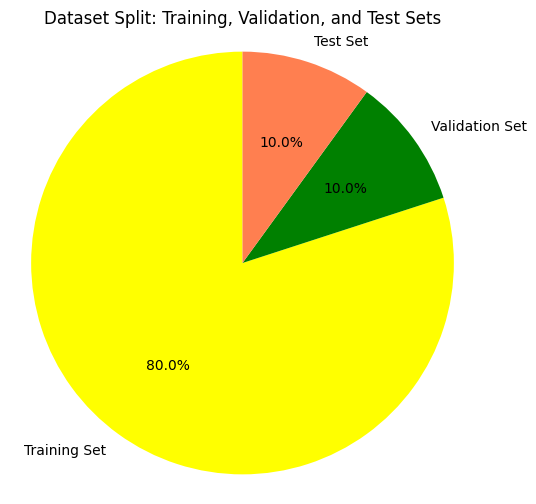

In [22]:
#Plotting
import matplotlib.pyplot as plt

# Assuming the dataset has 100 samples as an example
train_size = 80  # 80% training set
val_size = 10    # 10% validation set
test_size = 10   # 10% test set
labels = ['Training Set', 'Validation Set', 'Test Set']
sizes = [train_size, val_size, test_size]

colors = ['yellow', 'green', 'coral']
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Dataset Split: Training, Validation, and Test Sets')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()


In [123]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming images and labels are numpy arrays, convert them to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoader objects for training and validation
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Assuming test images and labels are numpy arrays, convert them to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a TensorDataset object for the test set
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create a DataLoader object for the test set
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)  # shuffle=False for test data



In [124]:
import torch.optim as optim  # PyTorch optimizers
from torch.optim import lr_scheduler  # PyTorch learning rate schedulers
import pickle

import torch.optim as optim
from torch.optim import lr_scheduler
# PyTorch optimizer (Adam) and scheduler (ReduceLROnPlateau)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =  UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Initialize history dictionary to store training and validation losses, accuracies, and metrics
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")
model_name="UNet3D_NP_HARP_UPDATED"
model_dir = os.path.join(os.getcwd(), "NewModels")
hist_dir=os.path.join(os.getcwd(), "NewHistory")
os.makedirs(model_dir, exist_ok=True)
os.makedirs(hist_dir, exist_ok=True)

early_stopping_patience=7

epochs_no_improve=0
best_val_loss=10000
num_epochs=250

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_dice': [], 'val_dice': [],
           'train_jaccard': [], 'val_jaccard': [], 'train_f1': [], 'val_f1': [], 'train_iou': [], 'val_iou': [],
           'train_osr': [], 'val_osr': [], 'train_usr': [], 'val_usr': [], 'train_asd': [], 'val_asd': [], 
           'train_hd': [], 'val_hd': []}

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0
    train_correct = 0
    train_dice, train_jaccard, train_f1, train_iou, train_osr, train_usr, train_asd, train_hd = 0, 0, 0, 0, 0, 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()  # PyTorch Adam optimizer has zero_grad()
        outputs = model(X_batch)  # Forward pass
        outputs = torch.sigmoid(outputs)  # Apply sigmoid for binary classification
        loss = bce_loss(y_batch.unsqueeze(1), outputs)  # Compute combined loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        train_loss += loss.item() * X_batch.size(0)

        # Calculate accuracy and metrics
        acc = calculate_accuracy(y_batch.unsqueeze(1), outputs)
        train_correct += acc.item() * X_batch.size(0)
        train_dice += dice_coefficient(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_jaccard += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_f1 += f1_score(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_iou += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)  # IoU (same as Jaccard)
        train_osr += over_segmentation_ratio(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_usr += under_segmentation_rate(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_asd += average_surface_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)
        train_hd += hausdorff_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_dice, val_jaccard, val_f1, val_iou, val_osr, val_usr, val_asd, val_hd = 0, 0, 0, 0, 0, 0, 0, 0

    with torch.no_grad():  # Disable gradient computation for validation
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            outputs = torch.sigmoid(outputs)
            loss = bce_loss(y_batch.unsqueeze(1), outputs)
            val_loss += loss.item() * X_batch.size(0)

            # Calculate accuracy and metrics
            acc = calculate_accuracy(y_batch.unsqueeze(1), outputs)
            val_correct += acc.item() * X_batch.size(0)
            val_dice += dice_coefficient(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_jaccard += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_f1 += f1_score(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_iou += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)  # IoU (same as Jaccard)
            val_osr += over_segmentation_ratio(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_usr += under_segmentation_rate(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_asd += average_surface_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)
            val_hd += hausdorff_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)

    # Step the scheduler with validation loss
    scheduler.step(val_loss / len(val_loader.dataset))

    # Calculate average losses, accuracies, and metrics
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    train_dice /= len(train_loader.dataset)
    val_dice /= len(val_loader.dataset)
    train_jaccard /= len(train_loader.dataset)
    val_jaccard /= len(val_loader.dataset)
    train_f1 /= len(train_loader.dataset)
    val_f1 /= len(val_loader.dataset)
    train_iou /= len(train_loader.dataset)
    val_iou /= len(val_loader.dataset)
    train_osr /= len(train_loader.dataset)
    val_osr /= len(val_loader.dataset)
    train_usr /= len(train_loader.dataset)
    val_usr /= len(val_loader.dataset)
    train_asd /= len(train_loader.dataset)
    val_asd /= len(val_loader.dataset)
    train_hd /= len(train_loader.dataset)
    val_hd /= len(val_loader.dataset)

    # Append the losses, accuracies, and metrics to history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_dice)
    history['train_jaccard'].append(train_jaccard)
    history['val_jaccard'].append(val_jaccard)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)
    history['train_osr'].append(train_osr)
    history['val_osr'].append(val_osr)
    history['train_usr'].append(train_usr)
    history['val_usr'].append(val_usr)
    history['train_asd'].append(train_asd)
    history['val_asd'].append(val_asd)
    history['train_hd'].append(train_hd)
    history['val_hd'].append(val_hd)

    # Print epoch summary
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Dice: {train_dice:.4f}, '
          f'Val Dice: {val_dice:.4f}, Train Jaccard: {train_jaccard:.4f}, Val Jaccard: {val_jaccard:.4f}, '
          f'Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}, '
          f'Train OSR: {train_osr:.4f}, Val OSR: {val_osr:.4f}, Train USR: {train_usr:.4f}, Val USR: {val_usr:.4f}, '
          f'Train ASD: {train_asd:.4f}, Val ASD: {val_asd:.4f}, Train HD: {train_hd:.4f}, Val HD: {val_hd:.4f}')

    # Early Stopping Check
    if val_loss < best_val_loss:
        print(f'Validation loss improved ({best_val_loss:.4f} -> {val_loss:.4f}). Saving model...')
        best_val_loss = val_loss
        weights_path = os.path.join(model_dir, f"{model_name}.pth")
        torch.save(model.state_dict(), weights_path)  # Save the model's state_dict
        epochs_no_improve = 0  # Reset the counter for early stopping
    else:
        epochs_no_improve += 1
        print(f'No improvement in validation loss for {epochs_no_improve} epochs.')

    # If the validation loss doesn't improve for `early_stopping_patience` epochs, stop the training
    if epochs_no_improve == early_stopping_patience:
        print(f'Early stopping triggered. No improvement in validation loss for {early_stopping_patience} consecutive epochs.')
        break  # Exit the training loop

# 4) Make sure models/ exists for saving



history_path = os.path.join(hist_dir, f"{model_name}_training_history.pkl")
with open(history_path, "wb") as f:
    pickle.dump(history, f)
print(f"Training history saved to '{history_path}'.")


Training on device: cuda


C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:66: DeprecationWarning: Please import `generate_binary_structure` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  conn = morphology.generate_binary_structure(y_true_np.ndim, 1)
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:69: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  true_surface = np.logical_xor(y_true_np, morphology.binary_erosion(y_true_np, conn))
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:70: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  pred_surface = np.logical_xor(y_pred_np, morphology.binary_erosion(y_pred_np, conn))
C:\Use

Epoch 1/250, Train Loss: 0.4487, Val Loss: 0.3228, Train Acc: 0.9205, Val Acc: 0.9847, Train Dice: 0.0109, Val Dice: 0.0001, Train Jaccard: 0.0056, Val Jaccard: 0.0001, Train F1: 0.9356, Val F1: 1.0000, Train IoU: 0.0056, Val IoU: 0.0001, Train OSR: 0.4042, Val OSR: 0.0938, Train USR: 0.5850, Val USR: 0.9063, Train ASD: 7.8947, Val ASD: 7.9217, Train HD: inf, Val HD: 50.2886
Validation loss improved (10000.0000 -> 0.3228). Saving model...
Epoch 2/250, Train Loss: 0.2809, Val Loss: 0.2322, Train Acc: 0.9853, Val Acc: 0.9861, Train Dice: 0.0001, Val Dice: 0.0001, Train Jaccard: 0.0001, Val Jaccard: 0.0001, Train F1: 0.9988, Val F1: 1.0000, Train IoU: 0.0001, Val IoU: 0.0001, Train OSR: 0.0440, Val OSR: 0.0000, Train USR: 0.9560, Val USR: 1.0000, Train ASD: 7.9094, Val ASD: 7.9217, Train HD: inf, Val HD: inf
Validation loss improved (0.3228 -> 0.2322). Saving model...
Epoch 3/250, Train Loss: 0.2015, Val Loss: 0.1712, Train Acc: 0.9877, Val Acc: 0.9901, Train Dice: 0.2946, Val Dice: 0.644

In [125]:
#Testing NP
import os
import pickle
import torch
import pandas as pd

# 1) Import your model class and metric functions here
# from your_model_file import UNet3DDropoutResiduals
# from your_metrics_file import (
#     bce_loss,
#     calculate_accuracy,
#     dice_coefficient,
#     jaccard_index,
#     f1_score,
#     over_segmentation_ratio,
#     under_segmentation_rate,
#     average_surface_distance,
#     hausdorff_distance
# )
# from your_data_file import test_loader

# 2) Paths and names
model_name="UNet3D_NP_HARP_UPDATED"
model_dir = os.path.join(os.getcwd(), "NewModels")
hist_dir=os.path.join(os.getcwd(), "NewHistory")

weights_path = os.path.join(model_dir, f"{model_name}.pth")
history_path = os.path.join(hist_dir, f"{model_name}_training_history.pkl")

# 3) Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 4) Load the model
model = UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

# 5) Load training history
with open(history_path, "rb") as f:
    history = pickle.load(f)

# 6) Evaluate on test set
test_loss = test_acc = test_dice = test_jaccard = test_f1 = test_iou = test_osr = test_usr = test_asd = test_hd = 0.0
n_samples = len(test_loader.dataset)

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = torch.sigmoid(model(X_batch))
        
        bs = X_batch.size(0)
        test_loss    += bce_loss(y_batch.unsqueeze(1), outputs).item() * bs
        test_acc     += calculate_accuracy(y_batch.unsqueeze(1), outputs).item() * bs
        test_dice    += dice_coefficient(y_batch.unsqueeze(1), outputs).item() * bs
        test_jaccard += jaccard_index(y_batch.unsqueeze(1), outputs).item() * bs
        test_f1      += f1_score(y_batch.unsqueeze(1), outputs).item() * bs
        test_iou     += jaccard_index(y_batch.unsqueeze(1), outputs).item() * bs
        test_osr     += over_segmentation_ratio(y_batch.unsqueeze(1), outputs).item() * bs
        test_usr     += under_segmentation_rate(y_batch.unsqueeze(1), outputs).item() * bs
        test_asd     += average_surface_distance(y_batch.unsqueeze(1), outputs) * bs
        test_hd      += hausdorff_distance(y_batch.unsqueeze(1), outputs) * bs

# 7) Compute averages
test_metrics = {
    'loss':    test_loss    / n_samples,
    'acc':     test_acc     / n_samples,
    'dice':    test_dice    / n_samples,
    'jaccard': test_jaccard / n_samples,
    'f1':      test_f1      / n_samples,
    'iou':     test_iou     / n_samples,
    'osr':     test_osr     / n_samples,
    'usr':     test_usr     / n_samples,
    'asd':     test_asd     / n_samples,
    'hd':      test_hd      / n_samples,
}

# 8) Build and print the final table
metrics = ['loss','acc','dice','jaccard','f1','iou','osr','usr','asd','hd']
train_vals = [history[f'train_{m}'][-1] for m in metrics]
val_vals   = [history[f'val_{m}'][-1]   for m in metrics]
test_vals  = [test_metrics[m]            for m in metrics]

df = pd.DataFrame({
    'Train': train_vals,
    'Val':   val_vals,
    'Test':  test_vals
}, index=metrics)

print("\n=== Final Metrics (Train / Val / Test) ===")
print(df.to_string(float_format="%.4f"))


Using device: cuda


C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:66: DeprecationWarning: Please import `generate_binary_structure` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  conn = morphology.generate_binary_structure(y_true_np.ndim, 1)
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:69: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  true_surface = np.logical_xor(y_true_np, morphology.binary_erosion(y_true_np, conn))
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:70: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  pred_surface = np.logical_xor(y_pred_np, morphology.binary_erosion(y_pred_np, conn))
C:\Use


=== Final Metrics (Train / Val / Test) ===
         Train    Val   Test
loss    0.0112 0.0128 0.0085
acc     0.9965 0.9958 0.9970
dice    0.8743 0.8454 0.8876
jaccard 0.7787 0.7411 0.7981
f1      0.9205 0.9055 0.9281
iou     0.7787 0.7411 0.7981
osr     0.0639 0.0796 0.0594
usr     0.0619 0.0750 0.0531
asd     7.8858 7.9217 8.0823
hd      3.3991 3.6605 3.1337


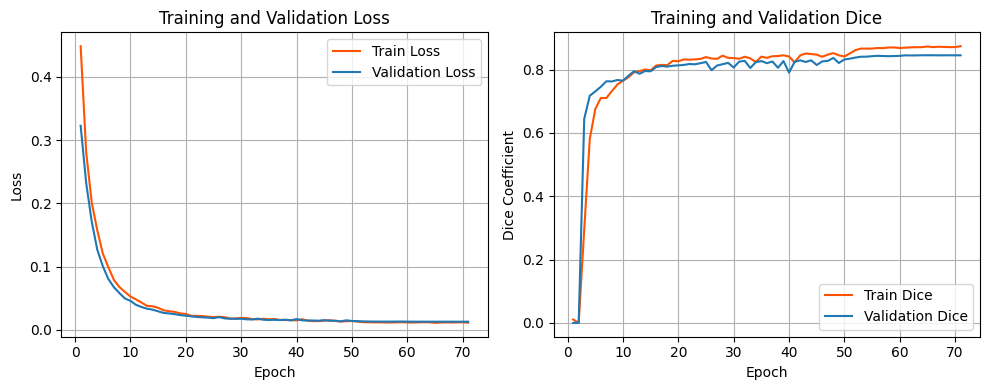

In [126]:
### Get from the train validation, test results previous cuda file because of leakage chance
import os
import pickle
import matplotlib.pyplot as plt

# Paths to model history
model_name="UNet3D_NP_HARP_UPDATED"
model_dir = os.path.join(os.getcwd(), "NewModels")
hist_dir=os.path.join(os.getcwd(), "NewHistory")

weights_path = os.path.join(model_dir, f"{model_name}.pth")
history_path = os.path.join(hist_dir, f"{model_name}_training_history.pkl")



# Load history dictionary
with open(history_path, "rb") as f:
    history = pickle.load(f)

# Extract training/validation loss and dice
train_loss = history.get('train_loss', [])
val_loss = history.get('val_loss', [])
train_dice = history.get('train_dice', [])
val_dice = history.get('val_dice', [])

epochs = range(1, len(train_loss) + 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Loss subplot
axs[0].plot(epochs, train_loss, label='Train Loss', color='#ff5300')
axs[0].plot(epochs, val_loss, label='Validation Loss', color='tab:blue')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Dice subplot
axs[1].plot(epochs, train_dice, label='Train Dice', color='#ff5300')
axs[1].plot(epochs, val_dice, label='Validation Dice', color='tab:blue')
axs[1].set_title('Training and Validation Dice')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Dice Coefficient')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


#### With Preprocessing

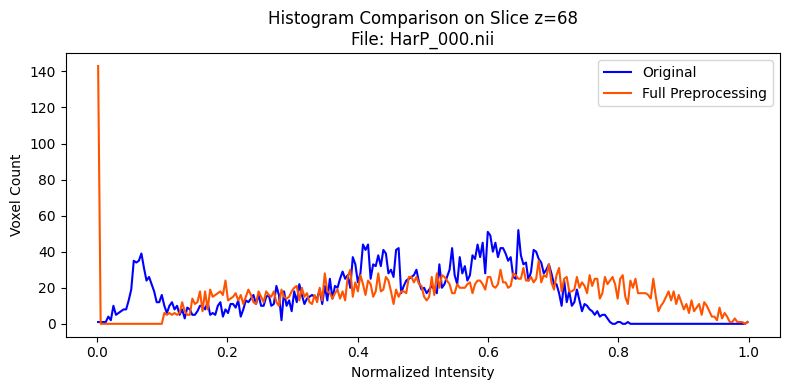

In [49]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Paths
images_dir    = r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\imageTr"
pre_dir       =  r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_Harp_Preprocessed"

# Find the first file
files = sorted([f for f in os.listdir(images_dir) if f.endswith((".nii",".nii.gz"))])
if not files:
    raise RuntimeError("No NIfTI files found in images_dir")
first_fname = files[0]

# Load original and CLAHE’d volumes
orig_img = nib.load(os.path.join(images_dir, first_fname)).get_fdata()
clahe_img = nib.load(os.path.join(pre_dir, first_fname)).get_fdata()

# Pick middle axial slice
slice_idx = orig_img.shape[2] // 2 +20
orig_slice  = orig_img[:, :, slice_idx]
clahe_slice = clahe_img[:, :, slice_idx]

# Normalize each slice to [0,1]
def normalize(x):
    mn, mx = x.min(), x.max()
    return (x - mn) / (mx - mn + 1e-8)

orig_norm  = normalize(orig_slice)
clahe_norm = normalize(clahe_slice)

# Compute histograms
bins = 256
hist_o, bin_edges = np.histogram(orig_norm.flatten(),  bins=bins, range=(0,1))
hist_c, _         = np.histogram(clahe_norm.flatten(), bins=bins, range=(0,1))
centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

# Plot
plt.figure(figsize=(8,4))
plt.plot(centers, hist_o, label="Original", color="blue")
plt.plot(centers, hist_c, label="Full Preprocessing",    color="#ff5300")
plt.title(f"Histogram Comparison on Slice z={slice_idx}\nFile: {first_fname}")
plt.xlabel("Normalized Intensity")
plt.ylabel("Voxel Count")
plt.legend()
plt.tight_layout()
plt.show()


In [133]:
import nibabel as nib
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Directories for images and labels
images_dir = r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_Harp_Preprocessed"
labels_dir = r'D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr'

# Function to load a .nii file
def load_nifti_file(filepath):
    img = nib.load(filepath)
    return img.get_fdata()

# List all image and label files
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.nii')])
label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.nii')])

# Verify that corresponding images and labels have the same names
assert len(image_files) == len(label_files)
for img_file, label_file in zip(image_files, label_files):
    assert img_file == label_file, f"Mismatched file: {img_file} and {label_file}"

# Load the data
images = [load_nifti_file(os.path.join(images_dir, f)) for f in image_files]
labels = [load_nifti_file(os.path.join(labels_dir, f)) for f in label_files]

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize image voxel values (between 0 and 1)
images = (images - np.min(images)) / (np.max(images) - np.min(images))

# Check shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


# Split into training, validation, and testing sets (80% train, 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")


Images shape: (135, 64, 64, 96)
Labels shape: (135, 64, 64, 96)
Training set shape: (108, 64, 64, 96)
Validation set shape: (13, 64, 64, 96)
Test set shape: (14, 64, 64, 96)


In [136]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming images and labels are numpy arrays, convert them to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoader objects for training and validation
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Assuming test images and labels are numpy arrays, convert them to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a TensorDataset object for the test set
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create a DataLoader object for the test set
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)  # shuffle=False for test data



In [137]:
# Training Preprocessing
import torch.optim as optim  # PyTorch optimizers
from torch.optim import lr_scheduler  # PyTorch learning rate schedulers
import pickle

import torch.optim as optim
from torch.optim import lr_scheduler
# PyTorch optimizer (Adam) and scheduler (ReduceLROnPlateau)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =  UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

model_dir = os.path.join(os.getcwd(), "NewModels")
hist_dir=os.path.join(os.getcwd(), "NewHistory")
os.makedirs(model_dir, exist_ok=True)
os.makedirs(hist_dir, exist_ok=True)

# Initialize history dictionary to store training and validation losses, accuracies, and metrics
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")
model_name="UNet3D_FP_UPDATED"
early_stopping_patience=7

epochs_no_improve=0
best_val_loss=10000
num_epochs=250

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_dice': [], 'val_dice': [],
           'train_jaccard': [], 'val_jaccard': [], 'train_f1': [], 'val_f1': [], 'train_iou': [], 'val_iou': [],
           'train_osr': [], 'val_osr': [], 'train_usr': [], 'val_usr': [], 'train_asd': [], 'val_asd': [], 
           'train_hd': [], 'val_hd': []}

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0
    train_correct = 0
    train_dice, train_jaccard, train_f1, train_iou, train_osr, train_usr, train_asd, train_hd = 0, 0, 0, 0, 0, 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()  # PyTorch Adam optimizer has zero_grad()
        outputs = model(X_batch)  # Forward pass
        outputs = torch.sigmoid(outputs)  # Apply sigmoid for binary classification
        loss = bce_loss(y_batch.unsqueeze(1), outputs)  # Compute combined loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        train_loss += loss.item() * X_batch.size(0)

        # Calculate accuracy and metrics
        acc = calculate_accuracy(y_batch.unsqueeze(1), outputs)
        train_correct += acc.item() * X_batch.size(0)
        train_dice += dice_coefficient(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_jaccard += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_f1 += f1_score(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_iou += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)  # IoU (same as Jaccard)
        train_osr += over_segmentation_ratio(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_usr += under_segmentation_rate(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_asd += average_surface_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)
        train_hd += hausdorff_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_dice, val_jaccard, val_f1, val_iou, val_osr, val_usr, val_asd, val_hd = 0, 0, 0, 0, 0, 0, 0, 0

    with torch.no_grad():  # Disable gradient computation for validation
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            outputs = torch.sigmoid(outputs)
            loss = bce_loss(y_batch.unsqueeze(1), outputs)
            val_loss += loss.item() * X_batch.size(0)

            # Calculate accuracy and metrics
            acc = calculate_accuracy(y_batch.unsqueeze(1), outputs)
            val_correct += acc.item() * X_batch.size(0)
            val_dice += dice_coefficient(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_jaccard += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_f1 += f1_score(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_iou += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)  # IoU (same as Jaccard)
            val_osr += over_segmentation_ratio(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_usr += under_segmentation_rate(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_asd += average_surface_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)
            val_hd += hausdorff_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)

    # Step the scheduler with validation loss
    scheduler.step(val_loss / len(val_loader.dataset))

    # Calculate average losses, accuracies, and metrics
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    train_dice /= len(train_loader.dataset)
    val_dice /= len(val_loader.dataset)
    train_jaccard /= len(train_loader.dataset)
    val_jaccard /= len(val_loader.dataset)
    train_f1 /= len(train_loader.dataset)
    val_f1 /= len(val_loader.dataset)
    train_iou /= len(train_loader.dataset)
    val_iou /= len(val_loader.dataset)
    train_osr /= len(train_loader.dataset)
    val_osr /= len(val_loader.dataset)
    train_usr /= len(train_loader.dataset)
    val_usr /= len(val_loader.dataset)
    train_asd /= len(train_loader.dataset)
    val_asd /= len(val_loader.dataset)
    train_hd /= len(train_loader.dataset)
    val_hd /= len(val_loader.dataset)

    # Append the losses, accuracies, and metrics to history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_dice)
    history['train_jaccard'].append(train_jaccard)
    history['val_jaccard'].append(val_jaccard)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)
    history['train_osr'].append(train_osr)
    history['val_osr'].append(val_osr)
    history['train_usr'].append(train_usr)
    history['val_usr'].append(val_usr)
    history['train_asd'].append(train_asd)
    history['val_asd'].append(val_asd)
    history['train_hd'].append(train_hd)
    history['val_hd'].append(val_hd)

    # Print epoch summary
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Dice: {train_dice:.4f}, '
          f'Val Dice: {val_dice:.4f}, Train Jaccard: {train_jaccard:.4f}, Val Jaccard: {val_jaccard:.4f}, '
          f'Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}, '
          f'Train OSR: {train_osr:.4f}, Val OSR: {val_osr:.4f}, Train USR: {train_usr:.4f}, Val USR: {val_usr:.4f}, '
          f'Train ASD: {train_asd:.4f}, Val ASD: {val_asd:.4f}, Train HD: {train_hd:.4f}, Val HD: {val_hd:.4f}')

    # Early Stopping Check
    if val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} -> {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        epochs_no_improve = 0  
        weights_path = os.path.join(model_dir, f"{model_name}.pth")
        torch.save(model.state_dict(), weights_path)
        print(f"Saved weights to '{weights_path}'")

    else:
        epochs_no_improve += 1
        print(f'No improvement in validation loss for {epochs_no_improve} epochs.')

    # If the validation loss doesn't improve for `early_stopping_patience` epochs, stop the training
    if epochs_no_improve == early_stopping_patience:
        print(f'Early stopping triggered. No improvement in validation loss for {early_stopping_patience} consecutive epochs.')
        break  # Exit the training loop


history_path = os.path.join(hist_dir, f"{model_name}_training_history.pkl")
with open(history_path, "wb") as f:
    pickle.dump(history, f)
print(f"Training history saved to '{history_path}'.")


Training on device: cuda


C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:66: DeprecationWarning: Please import `generate_binary_structure` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  conn = morphology.generate_binary_structure(y_true_np.ndim, 1)
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:69: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  true_surface = np.logical_xor(y_true_np, morphology.binary_erosion(y_true_np, conn))
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:70: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  pred_surface = np.logical_xor(y_pred_np, morphology.binary_erosion(y_pred_np, conn))
C:\Use

Epoch 1/250, Train Loss: 0.5325, Val Loss: 0.3942, Train Acc: 0.8545, Val Acc: 0.9862, Train Dice: 0.1220, Val Dice: 0.2734, Train Jaccard: 0.0671, Val Jaccard: 0.1586, Train F1: 0.7453, Val F1: 0.7012, Train IoU: 0.0671, Val IoU: 0.1586, Train OSR: 0.4618, Val OSR: 0.1341, Train USR: 0.4163, Val USR: 0.5925, Train ASD: 7.8915, Val ASD: 7.9217, Train HD: 45.5991, Val HD: 54.7629
Validation loss improved (10000.0000 -> 0.3942). Saving model...
Saved weights to 'd:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\NewModels\UNet3D_FP_UPDATED.pth'
Epoch 2/250, Train Loss: 0.3367, Val Loss: 0.2805, Train Acc: 0.9870, Val Acc: 0.9890, Train Dice: 0.3407, Val Dice: 0.5280, Train Jaccard: 0.2093, Val Jaccard: 0.3601, Train F1: 0.7051, Val F1: 0.7539, Train IoU: 0.2093, Val IoU: 0.3601, Train OSR: 0.1183, Val OSR: 0.1432, Train USR: 0.5411, Val USR: 0.3289, Train ASD: 7.9287, Val ASD: 7.9217, Train HD: 30.7109, Val HD: 16.5328
Validation loss improved (0.3942 -> 0.2805). Saving model...
Save

In [138]:
# TEsting FP
import os
import pickle
import torch
import pandas as pd

model_name = "UNet3D_FP_UPDATED"
model_dir = os.path.join(os.getcwd(), "NewModels")
hist_dir=os.path.join(os.getcwd(), "NewHistory")


weights_path = os.path.join(model_dir, f"{model_name}.pth")
history_path = os.path.join(hist_dir, f"{model_name}_training_history.pkl")

# 3) Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 4) Load the model
model = UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

# 5) Load training history
with open(history_path, "rb") as f:
    history = pickle.load(f)

# 6) Evaluate on test set
test_loss = test_acc = test_dice = test_jaccard = test_f1 = test_iou = test_osr = test_usr = test_asd = test_hd = 0.0
n_samples = len(test_loader.dataset)

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = torch.sigmoid(model(X_batch))
        
        bs = X_batch.size(0)
        test_loss    += bce_loss(y_batch.unsqueeze(1), outputs).item() * bs
        test_acc     += calculate_accuracy(y_batch.unsqueeze(1), outputs).item() * bs
        test_dice    += dice_coefficient(y_batch.unsqueeze(1), outputs).item() * bs
        test_jaccard += jaccard_index(y_batch.unsqueeze(1), outputs).item() * bs
        test_f1      += f1_score(y_batch.unsqueeze(1), outputs).item() * bs
        test_iou     += jaccard_index(y_batch.unsqueeze(1), outputs).item() * bs
        test_osr     += over_segmentation_ratio(y_batch.unsqueeze(1), outputs).item() * bs
        test_usr     += under_segmentation_rate(y_batch.unsqueeze(1), outputs).item() * bs
        test_asd     += average_surface_distance(y_batch.unsqueeze(1), outputs) * bs
        test_hd      += hausdorff_distance(y_batch.unsqueeze(1), outputs) * bs

# 7) Compute averages
test_metrics = {
    'loss':    test_loss    / n_samples,
    'acc':     test_acc     / n_samples,
    'dice':    test_dice    / n_samples,
    'jaccard': test_jaccard / n_samples,
    'f1':      test_f1      / n_samples,
    'iou':     test_iou     / n_samples,
    'osr':     test_osr     / n_samples,
    'usr':     test_usr     / n_samples,
    'asd':     test_asd     / n_samples,
    'hd':      test_hd      / n_samples,
}

# 8) Build and print the final table
metrics = ['loss','acc','dice','jaccard','f1','iou','osr','usr','asd','hd']
train_vals = [history[f'train_{m}'][-1] for m in metrics]
val_vals   = [history[f'val_{m}'][-1]   for m in metrics]
test_vals  = [test_metrics[m]            for m in metrics]

df = pd.DataFrame({
    'Train': train_vals,
    'Val':   val_vals,
    'Test':  test_vals
}, index=metrics)

print("\n=== Final Metrics (Train / Val / Test) ===")
print(df.to_string(float_format="%.4f"))


Using device: cuda


C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:66: DeprecationWarning: Please import `generate_binary_structure` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  conn = morphology.generate_binary_structure(y_true_np.ndim, 1)
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:69: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  true_surface = np.logical_xor(y_true_np, morphology.binary_erosion(y_true_np, conn))
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:70: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  pred_surface = np.logical_xor(y_pred_np, morphology.binary_erosion(y_pred_np, conn))
C:\Use


=== Final Metrics (Train / Val / Test) ===
         Train    Val   Test
loss    0.0138 0.0143 0.0103
acc     0.9962 0.9955 0.9967
dice    0.8651 0.8374 0.8753
jaccard 0.7648 0.7292 0.7784
f1      0.9153 0.9009 0.9206
iou     0.7648 0.7292 0.7784
osr     0.0705 0.0854 0.0665
usr     0.0645 0.0772 0.0583
asd     7.9161 7.9217 8.0823
hd      3.2654 3.8091 3.0794


#### With CLAHE only ( Not presented)

In [40]:
import os
import nibabel as nib
import numpy as np
from skimage import exposure

# Directories
images_dir = r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\imageTr"
output_dir = os.path.join(os.getcwd(), "3DCLAHE_PREPROCESSED")
os.makedirs(output_dir, exist_ok=True)

# Function to apply 3D CLAHE on a NIfTI image
def apply_3d_clahe(image_data, clip_limit=0.03, mask_background=True):
    # Normalize to [0,1]
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    normalized = (image_data - min_val) / (max_val - min_val + 1e-8)
    # Optionally mask background
    if mask_background:
        mask = normalized > 0
        normalized = normalized * mask
    # CLAHE
    clahe = exposure.equalize_adapthist(normalized, clip_limit=clip_limit)
    # Reapply mask
    if mask_background:
        clahe = clahe * mask
    return clahe

# Process and save each image
for fname in sorted(os.listdir(images_dir)):
    if fname.endswith(".nii") or fname.endswith(".nii.gz"):
        in_path = os.path.join(images_dir, fname)
        img = nib.load(in_path)
        data = img.get_fdata()
        
        # Apply CLAHE
        clahe_data = apply_3d_clahe(data, clip_limit=0.03, mask_background=True)
        
        # Save preprocessed image
        out_img = nib.Nifti1Image(clahe_data.astype(np.float32), img.affine, img.header)
        out_path = os.path.join(output_dir, fname)
        nib.save(out_img, out_path)
        print(f"Saved preprocessed image: {out_path}")

print("All images processed and saved to 3DCLAHE_PREPROCESSED.")


Saved preprocessed image: d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\3DCLAHE_PREPROCESSED\HarP_000.nii
Saved preprocessed image: d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\3DCLAHE_PREPROCESSED\HarP_001.nii
Saved preprocessed image: d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\3DCLAHE_PREPROCESSED\HarP_002.nii
Saved preprocessed image: d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\3DCLAHE_PREPROCESSED\HarP_003.nii
Saved preprocessed image: d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\3DCLAHE_PREPROCESSED\HarP_004.nii
Saved preprocessed image: d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\3DCLAHE_PREPROCESSED\HarP_005.nii
Saved preprocessed image: d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\3DCLAHE_PREPROCESSED\HarP_006.nii
Saved preprocessed image: d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\3DCLAHE_PREPROCESSED\HarP_007.nii
Saved preprocessed image: d:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D

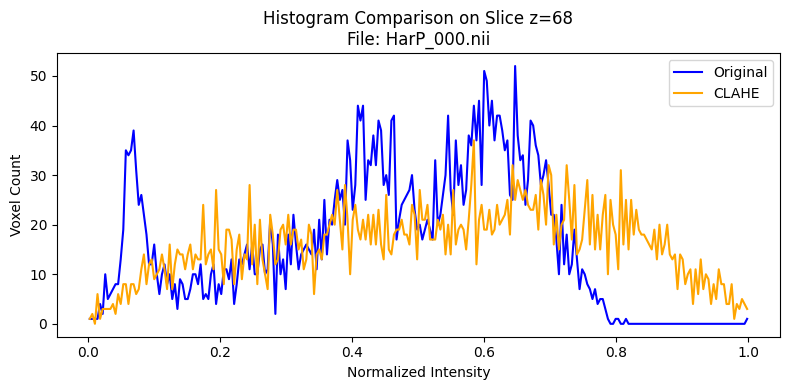

In [109]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Paths
images_dir    = r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\imageTr"
pre_dir       = os.path.join(os.getcwd(), "3DCLAHE_PREPROCESSED")

# Find the first file
files = sorted([f for f in os.listdir(images_dir) if f.endswith((".nii",".nii.gz"))])
if not files:
    raise RuntimeError("No NIfTI files found in images_dir")
first_fname = files[0]

# Load original and CLAHE’d volumes
orig_img = nib.load(os.path.join(images_dir, first_fname)).get_fdata()
clahe_img = nib.load(os.path.join(pre_dir, first_fname)).get_fdata()

# Pick middle axial slice
slice_idx = orig_img.shape[2] // 2 +20
orig_slice  = orig_img[:, :, slice_idx]
clahe_slice = clahe_img[:, :, slice_idx]

# Normalize each slice to [0,1]
def normalize(x):
    mn, mx = x.min(), x.max()
    return (x - mn) / (mx - mn + 1e-8)

orig_norm  = normalize(orig_slice)
clahe_norm = normalize(clahe_slice)

# Compute histograms
bins = 256
hist_o, bin_edges = np.histogram(orig_norm.flatten(),  bins=bins, range=(0,1))
hist_c, _         = np.histogram(clahe_norm.flatten(), bins=bins, range=(0,1))
centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

# Plot
plt.figure(figsize=(8,4))
plt.plot(centers, hist_o, label="Original", color="blue")
plt.plot(centers, hist_c, label="CLAHE",    color="orange")
plt.title(f"Histogram Comparison on Slice z={slice_idx}\nFile: {first_fname}")
plt.xlabel("Normalized Intensity")
plt.ylabel("Voxel Count")
plt.legend()
plt.tight_layout()
plt.show()


In [127]:
import nibabel as nib
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Directories for images and labels
images_dir = r"D:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\3DCLAHE_PREPROCESSED"
# images_dir = r'D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_Harp_Preprocessed'
labels_dir = r'D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr'

# Function to load a .nii file
def load_nifti_file(filepath):
    img = nib.load(filepath)
    return img.get_fdata()

# List all image and label files
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.nii')])
label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.nii')])

# Verify that corresponding images and labels have the same names
assert len(image_files) == len(label_files)
for img_file, label_file in zip(image_files, label_files):
    assert img_file == label_file, f"Mismatched file: {img_file} and {label_file}"

# Load the data
images = [load_nifti_file(os.path.join(images_dir, f)) for f in image_files]
labels = [load_nifti_file(os.path.join(labels_dir, f)) for f in label_files]

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize image voxel values (between 0 and 1)
images = (images - np.min(images)) / (np.max(images) - np.min(images))

# Check shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


# Split into training, validation, and testing sets (80% train, 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")


Images shape: (135, 64, 64, 96)
Labels shape: (135, 64, 64, 96)
Training set shape: (108, 64, 64, 96)
Validation set shape: (13, 64, 64, 96)
Test set shape: (14, 64, 64, 96)


In [128]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming images and labels are numpy arrays, convert them to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoader objects for training and validation
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Assuming test images and labels are numpy arrays, convert them to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a TensorDataset object for the test set
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create a DataLoader object for the test set
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)  # shuffle=False for test data



In [129]:
import torch.optim as optim  # PyTorch optimizers
from torch.optim import lr_scheduler  # PyTorch learning rate schedulers
import pickle

import torch.optim as optim
from torch.optim import lr_scheduler
# PyTorch optimizer (Adam) and scheduler (ReduceLROnPlateau)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =  UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

model_dir = os.path.join(os.getcwd(), "NewModels")
hist_dir=os.path.join(os.getcwd(), "NewHistory")
os.makedirs(model_dir, exist_ok=True)
os.makedirs(hist_dir, exist_ok=True)

# Initialize history dictionary to store training and validation losses, accuracies, and metrics
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")
model_name="UNet3D_3D_CLAHE_UPDATED"
early_stopping_patience=7

epochs_no_improve=0
best_val_loss=10000
num_epochs=250

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_dice': [], 'val_dice': [],
           'train_jaccard': [], 'val_jaccard': [], 'train_f1': [], 'val_f1': [], 'train_iou': [], 'val_iou': [],
           'train_osr': [], 'val_osr': [], 'train_usr': [], 'val_usr': [], 'train_asd': [], 'val_asd': [], 
           'train_hd': [], 'val_hd': []}

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0
    train_correct = 0
    train_dice, train_jaccard, train_f1, train_iou, train_osr, train_usr, train_asd, train_hd = 0, 0, 0, 0, 0, 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()  # PyTorch Adam optimizer has zero_grad()
        outputs = model(X_batch)  # Forward pass
        outputs = torch.sigmoid(outputs)  # Apply sigmoid for binary classification
        loss = bce_loss(y_batch.unsqueeze(1), outputs)  # Compute combined loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        train_loss += loss.item() * X_batch.size(0)

        # Calculate accuracy and metrics
        acc = calculate_accuracy(y_batch.unsqueeze(1), outputs)
        train_correct += acc.item() * X_batch.size(0)
        train_dice += dice_coefficient(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_jaccard += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_f1 += f1_score(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_iou += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)  # IoU (same as Jaccard)
        train_osr += over_segmentation_ratio(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_usr += under_segmentation_rate(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_asd += average_surface_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)
        train_hd += hausdorff_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_dice, val_jaccard, val_f1, val_iou, val_osr, val_usr, val_asd, val_hd = 0, 0, 0, 0, 0, 0, 0, 0

    with torch.no_grad():  # Disable gradient computation for validation
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            outputs = torch.sigmoid(outputs)
            loss = bce_loss(y_batch.unsqueeze(1), outputs)
            val_loss += loss.item() * X_batch.size(0)

            # Calculate accuracy and metrics
            acc = calculate_accuracy(y_batch.unsqueeze(1), outputs)
            val_correct += acc.item() * X_batch.size(0)
            val_dice += dice_coefficient(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_jaccard += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_f1 += f1_score(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_iou += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)  # IoU (same as Jaccard)
            val_osr += over_segmentation_ratio(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_usr += under_segmentation_rate(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_asd += average_surface_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)
            val_hd += hausdorff_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)

    # Step the scheduler with validation loss
    scheduler.step(val_loss / len(val_loader.dataset))

    # Calculate average losses, accuracies, and metrics
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    train_dice /= len(train_loader.dataset)
    val_dice /= len(val_loader.dataset)
    train_jaccard /= len(train_loader.dataset)
    val_jaccard /= len(val_loader.dataset)
    train_f1 /= len(train_loader.dataset)
    val_f1 /= len(val_loader.dataset)
    train_iou /= len(train_loader.dataset)
    val_iou /= len(val_loader.dataset)
    train_osr /= len(train_loader.dataset)
    val_osr /= len(val_loader.dataset)
    train_usr /= len(train_loader.dataset)
    val_usr /= len(val_loader.dataset)
    train_asd /= len(train_loader.dataset)
    val_asd /= len(val_loader.dataset)
    train_hd /= len(train_loader.dataset)
    val_hd /= len(val_loader.dataset)

    # Append the losses, accuracies, and metrics to history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_dice)
    history['train_jaccard'].append(train_jaccard)
    history['val_jaccard'].append(val_jaccard)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)
    history['train_osr'].append(train_osr)
    history['val_osr'].append(val_osr)
    history['train_usr'].append(train_usr)
    history['val_usr'].append(val_usr)
    history['train_asd'].append(train_asd)
    history['val_asd'].append(val_asd)
    history['train_hd'].append(train_hd)
    history['val_hd'].append(val_hd)

    # Print epoch summary
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Dice: {train_dice:.4f}, '
          f'Val Dice: {val_dice:.4f}, Train Jaccard: {train_jaccard:.4f}, Val Jaccard: {val_jaccard:.4f}, '
          f'Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}, '
          f'Train OSR: {train_osr:.4f}, Val OSR: {val_osr:.4f}, Train USR: {train_usr:.4f}, Val USR: {val_usr:.4f}, '
          f'Train ASD: {train_asd:.4f}, Val ASD: {val_asd:.4f}, Train HD: {train_hd:.4f}, Val HD: {val_hd:.4f}')

    # Early Stopping Check
    if val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} -> {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        epochs_no_improve = 0  
        weights_path = os.path.join(model_dir, f"{model_name}.pth")
        torch.save(model.state_dict(), weights_path)
        print(f"Saved weights to '{weights_path}'")

    else:
        epochs_no_improve += 1
        print(f'No improvement in validation loss for {epochs_no_improve} epochs.')

    # If the validation loss doesn't improve for `early_stopping_patience` epochs, stop the training
    if epochs_no_improve == early_stopping_patience:
        print(f'Early stopping triggered. No improvement in validation loss for {early_stopping_patience} consecutive epochs.')
        break  # Exit the training loop


history_path = os.path.join(hist_dir, f"{model_name}_training_history.pkl")
with open(history_path, "wb") as f:
    pickle.dump(history, f)
print(f"Training history saved to '{history_path}'.")


Training on device: cuda


C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:66: DeprecationWarning: Please import `generate_binary_structure` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  conn = morphology.generate_binary_structure(y_true_np.ndim, 1)
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:69: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  true_surface = np.logical_xor(y_true_np, morphology.binary_erosion(y_true_np, conn))
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:70: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  pred_surface = np.logical_xor(y_pred_np, morphology.binary_erosion(y_pred_np, conn))
C:\Use

Epoch 1/250, Train Loss: 0.4333, Val Loss: 0.3142, Train Acc: 0.9419, Val Acc: 0.9906, Train Dice: 0.4760, Val Dice: 0.6306, Train Jaccard: 0.3316, Val Jaccard: 0.4637, Train F1: 0.7375, Val F1: 0.7956, Train IoU: 0.3316, Val IoU: 0.4637, Train OSR: 0.3898, Val OSR: 0.1490, Train USR: 0.1342, Val USR: 0.2205, Train ASD: 7.8824, Val ASD: 7.9217, Train HD: 28.6712, Val HD: 14.8814
Validation loss improved (10000.0000 -> 0.3142). Saving model...
Saved weights to 'd:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\NewModels\UNet3D_3D_CLAHE_UPDATED.pth'
Epoch 2/250, Train Loss: 0.2662, Val Loss: 0.2174, Train Acc: 0.9910, Val Acc: 0.9921, Train Dice: 0.6686, Val Dice: 0.6923, Train Jaccard: 0.5043, Val Jaccard: 0.5328, Train F1: 0.8109, Val F1: 0.8227, Train IoU: 0.5043, Val IoU: 0.5328, Train OSR: 0.1490, Val OSR: 0.1234, Train USR: 0.1824, Val USR: 0.1843, Train ASD: 7.9164, Val ASD: 7.9217, Train HD: 12.4511, Val HD: 11.7708
Validation loss improved (0.3142 -> 0.2174). Saving model..

In [132]:
# TEsting CLAHE
import os
import pickle
import torch
import pandas as pd

# 1) Import your model class and metric functions here
# from your_model_file import UNet3DDropoutResiduals
# from your_metrics_file import (
#     bce_loss,
#     calculate_accuracy,
#     dice_coefficient,
#     jaccard_index,
#     f1_score,
#     over_segmentation_ratio,
#     under_segmentation_rate,
#     average_surface_distance,
#     hausdorff_distance
# )
# from your_data_file import test_loader

# 2) Paths and names
model_name = "UNet3D_3D_CLAHE_UPDATED"
model_dir = os.path.join(os.getcwd(), "NewModels")
hist_dir=os.path.join(os.getcwd(), "NewHistory")


weights_path = os.path.join(model_dir, f"{model_name}.pth")
history_path = os.path.join(hist_dir, f"{model_name}_training_history.pkl")

# 3) Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 4) Load the model
model = UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

# 5) Load training history
with open(history_path, "rb") as f:
    history = pickle.load(f)

# 6) Evaluate on test set
test_loss = test_acc = test_dice = test_jaccard = test_f1 = test_iou = test_osr = test_usr = test_asd = test_hd = 0.0
n_samples = len(test_loader.dataset)

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = torch.sigmoid(model(X_batch))
        
        bs = X_batch.size(0)
        test_loss    += bce_loss(y_batch.unsqueeze(1), outputs).item() * bs
        test_acc     += calculate_accuracy(y_batch.unsqueeze(1), outputs).item() * bs
        test_dice    += dice_coefficient(y_batch.unsqueeze(1), outputs).item() * bs
        test_jaccard += jaccard_index(y_batch.unsqueeze(1), outputs).item() * bs
        test_f1      += f1_score(y_batch.unsqueeze(1), outputs).item() * bs
        test_iou     += jaccard_index(y_batch.unsqueeze(1), outputs).item() * bs
        test_osr     += over_segmentation_ratio(y_batch.unsqueeze(1), outputs).item() * bs
        test_usr     += under_segmentation_rate(y_batch.unsqueeze(1), outputs).item() * bs
        test_asd     += average_surface_distance(y_batch.unsqueeze(1), outputs) * bs
        test_hd      += hausdorff_distance(y_batch.unsqueeze(1), outputs) * bs

# 7) Compute averages
test_metrics = {
    'loss':    test_loss    / n_samples,
    'acc':     test_acc     / n_samples,
    'dice':    test_dice    / n_samples,
    'jaccard': test_jaccard / n_samples,
    'f1':      test_f1      / n_samples,
    'iou':     test_iou     / n_samples,
    'osr':     test_osr     / n_samples,
    'usr':     test_usr     / n_samples,
    'asd':     test_asd     / n_samples,
    'hd':      test_hd      / n_samples,
}

# 8) Build and print the final table
metrics = ['loss','acc','dice','jaccard','f1','iou','osr','usr','asd','hd']
train_vals = [history[f'train_{m}'][-1] for m in metrics]
val_vals   = [history[f'val_{m}'][-1]   for m in metrics]
test_vals  = [test_metrics[m]            for m in metrics]

df = pd.DataFrame({
    'Train': train_vals,
    'Val':   val_vals,
    'Test':  test_vals
}, index=metrics)

print("\n=== Final Metrics (Train / Val / Test) ===")
print(df.to_string(float_format="%.4f"))


Using device: cuda


C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:66: DeprecationWarning: Please import `generate_binary_structure` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  conn = morphology.generate_binary_structure(y_true_np.ndim, 1)
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:69: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  true_surface = np.logical_xor(y_true_np, morphology.binary_erosion(y_true_np, conn))
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:70: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  pred_surface = np.logical_xor(y_pred_np, morphology.binary_erosion(y_pred_np, conn))
C:\Use


=== Final Metrics (Train / Val / Test) ===
         Train    Val   Test
loss    0.0119 0.0133 0.0093
acc     0.9965 0.9957 0.9969
dice    0.8721 0.8446 0.8844
jaccard 0.7752 0.7404 0.7929
f1      0.9192 0.9052 0.9261
iou     0.7752 0.7404 0.7929
osr     0.0622 0.0827 0.0648
usr     0.0657 0.0727 0.0509
asd     7.9187 7.9217 8.0823
hd      3.3507 3.9047 2.9891


### Qualitative Testing

#### Overlays

In [101]:
import matplotlib.pyplot as plt

def plot_3x2_overlays(img, gt, preds_dict, method_names, slice_idx, case_idx):
    """
    Plots overlays in a 3-row × 2-col grid:
    Row 1: Input | Ground Truth
    Row 2: NP | CL
    Row 3: SCE | FP
    """
    fig, axs = plt.subplots(3, 2, figsize=(8, 12))
    # Row 1
    axs[0, 0].imshow(img[slice_idx], cmap='gray')
    axs[0, 0].set_title("Input MRI")
    axs[0, 0].axis('off')
    axs[0, 1].imshow(img[slice_idx], cmap='gray')
    axs[0, 1].imshow(gt[slice_idx], cmap='Greens', alpha=0.4)
    axs[0, 1].set_title("Ground Truth")
    axs[0, 1].axis('off')
    # Row 2
    axs[1, 0].imshow(img[slice_idx], cmap='gray')
    axs[1, 0].imshow(preds_dict['NP'][slice_idx], cmap='Reds', alpha=0.4)
    axs[1, 0].contour(gt[slice_idx], colors='lime', linewidths=1)
    axs[1, 0].set_title("Pred: NP")
    axs[1, 0].axis('off')
    axs[1, 1].imshow(img[slice_idx], cmap='gray')
    axs[1, 1].imshow(preds_dict['CL'][slice_idx], cmap='Reds', alpha=0.4)
    axs[1, 1].contour(gt[slice_idx], colors='lime', linewidths=1)
    axs[1, 1].set_title("Pred: CL")
    axs[1, 1].axis('off')
    # Row 3
    axs[2, 0].imshow(img[slice_idx], cmap='gray')
    axs[2, 0].imshow(preds_dict['SCE'][slice_idx], cmap='Reds', alpha=0.4)
    axs[2, 0].contour(gt[slice_idx], colors='lime', linewidths=1)
    axs[2, 0].set_title("Pred: SCE")
    axs[2, 0].axis('off')
    axs[2, 1].imshow(img[slice_idx], cmap='gray')
    axs[2, 1].imshow(preds_dict['FP'][slice_idx], cmap='Reds', alpha=0.4)
    axs[2, 1].contour(gt[slice_idx], colors='lime', linewidths=1)
    axs[2, 1].set_title("Pred: FP")
    axs[2, 1].axis('off')
    plt.suptitle(f"Test Case #{case_idx} — Slice {slice_idx}", fontsize=14)
    plt.tight_layout()
    plt.show()


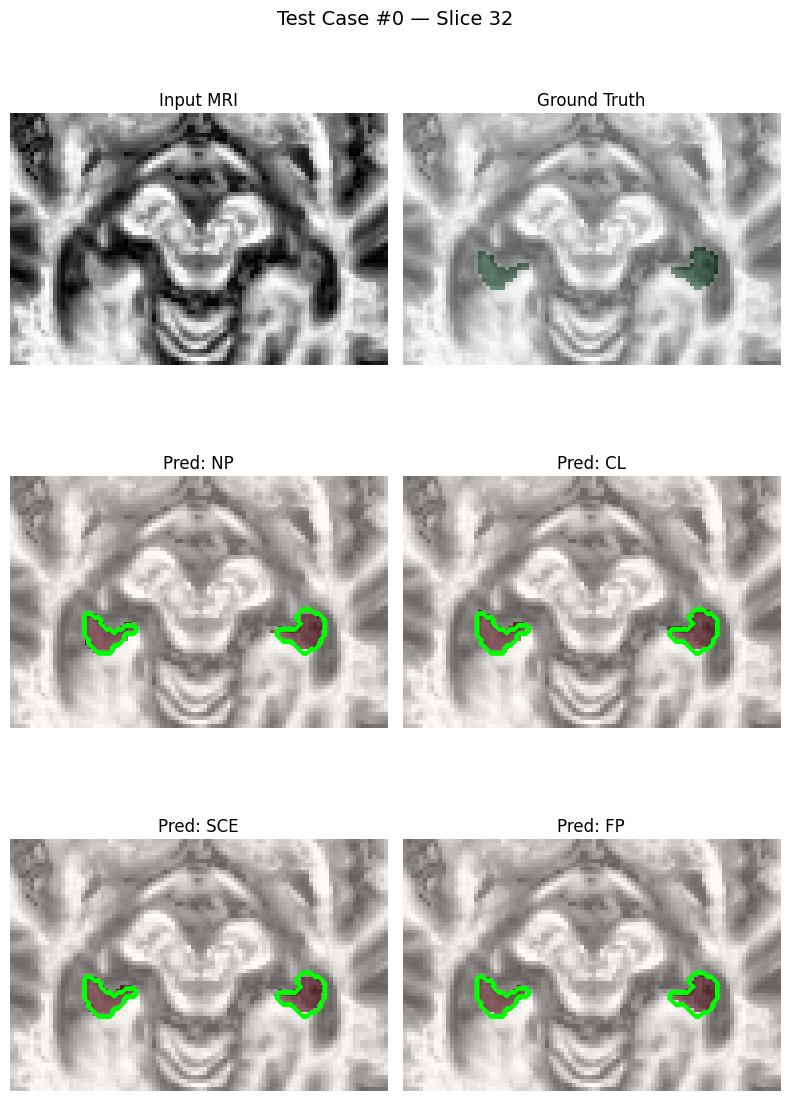

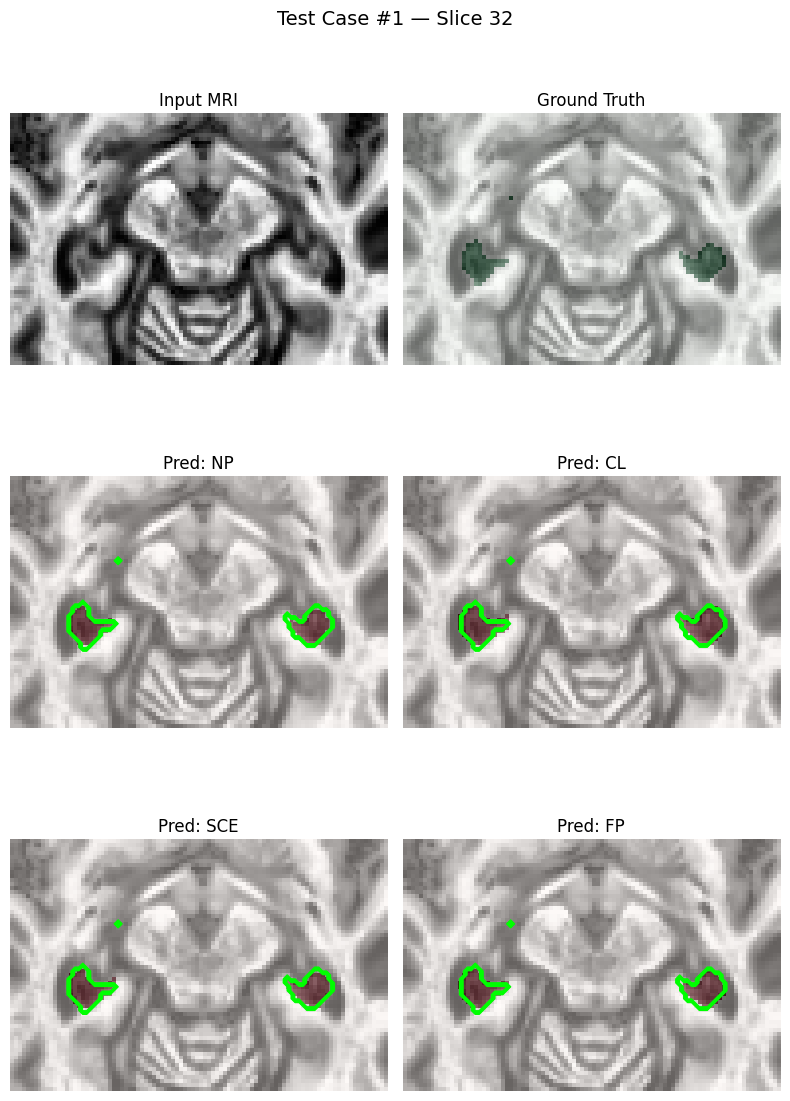

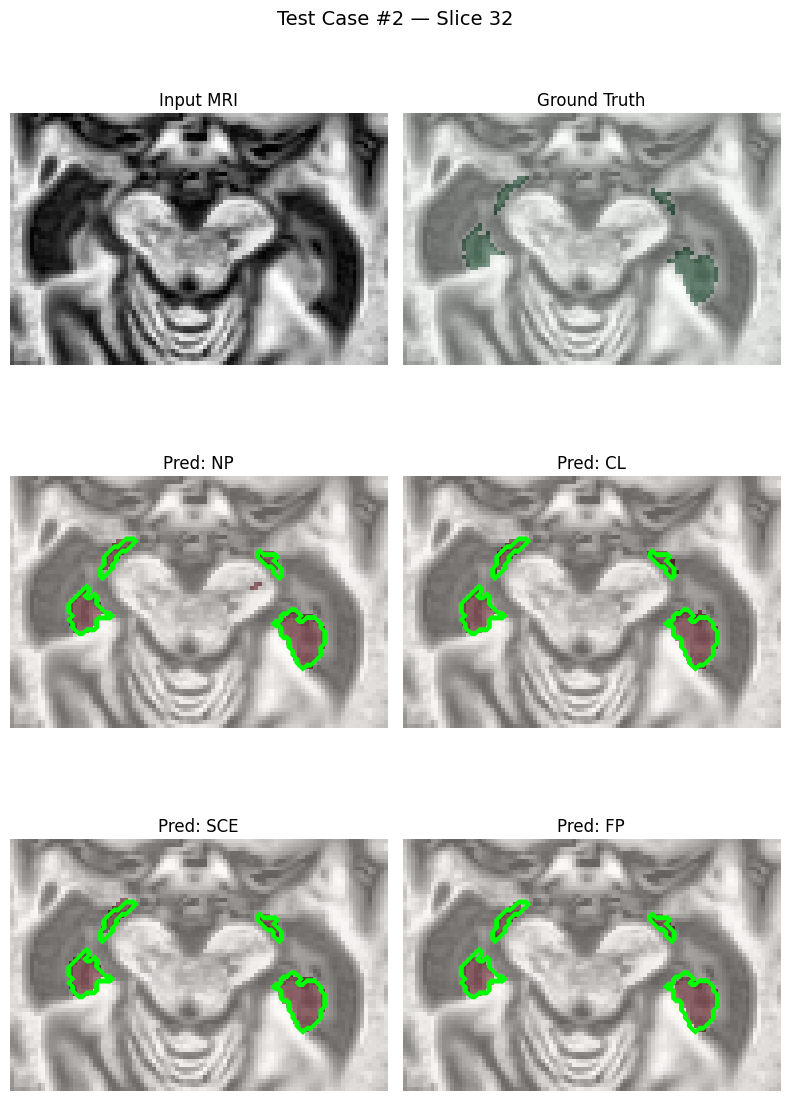

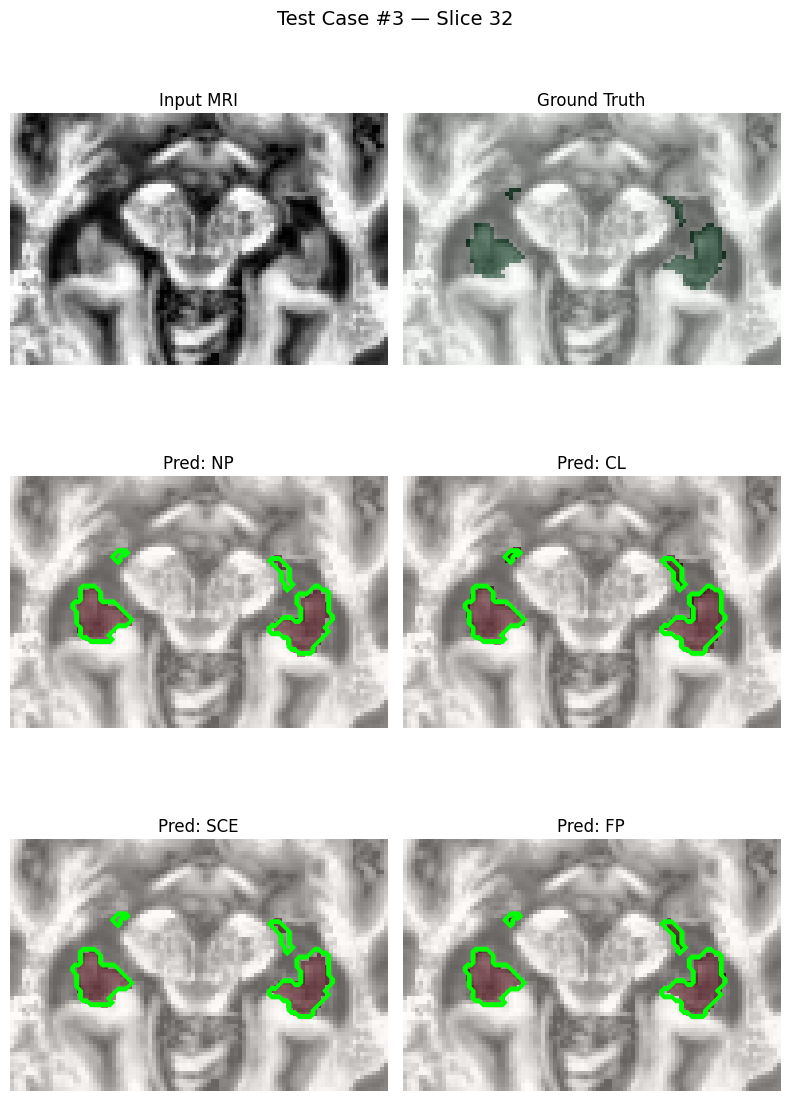

In [83]:
# Load your models as before
model_codes = ['NP', 'CL', 'SCE', 'FP']
model_names = [
    ("NP", "UNet3D_NO_PREPROCESSING"),
    ("CL", "UNet3D_3D_CLAHE_ONLY"),
    ("SCE", "UNet3D_SCE3DWT_ONLY"),
    ("FP", "UNet3DdropOutResidualsV2_BCELoss")
]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from segmentation import UNet3DDropoutResiduals
models = {}
for code, model_short in model_names:
    model = UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)
    model.load_state_dict(torch.load(f"models/{model_short}.pth", map_location=device))
    model.eval()
    models[code] = model

# Choose the number of cases and slice index to visualize
n_cases = 3   # How many test cases to show
slice_idx = 32  # Or pick a central slice, e.g., img.shape[0]//2
global_case_idx = 0
for case_idx, (img_tensor, gt_tensor) in enumerate(test_loader):
    for b in range(img_tensor.shape[0]):
        img_b = img_tensor[b].cpu().numpy().squeeze()
        gt_b  = gt_tensor[b].cpu().numpy().squeeze()
        preds = {}
        for code in model_codes:
            with torch.no_grad():
                pred = torch.sigmoid(models[code](img_tensor[b:b+1].to(device))).cpu().numpy().squeeze()
                preds[code] = (pred >= 0.5).astype(np.float32)
        D = img_b.shape[0]
        slice_idx = D // 2
        plot_3x2_overlays(img_b, gt_b, preds, model_codes, slice_idx, global_case_idx)
        global_case_idx += 1
    if global_case_idx >= n_cases:
        break




In [54]:
print("Image shape:", img.shape)  # Should print (D, H, W)


Image shape: (2, 64, 64, 96)


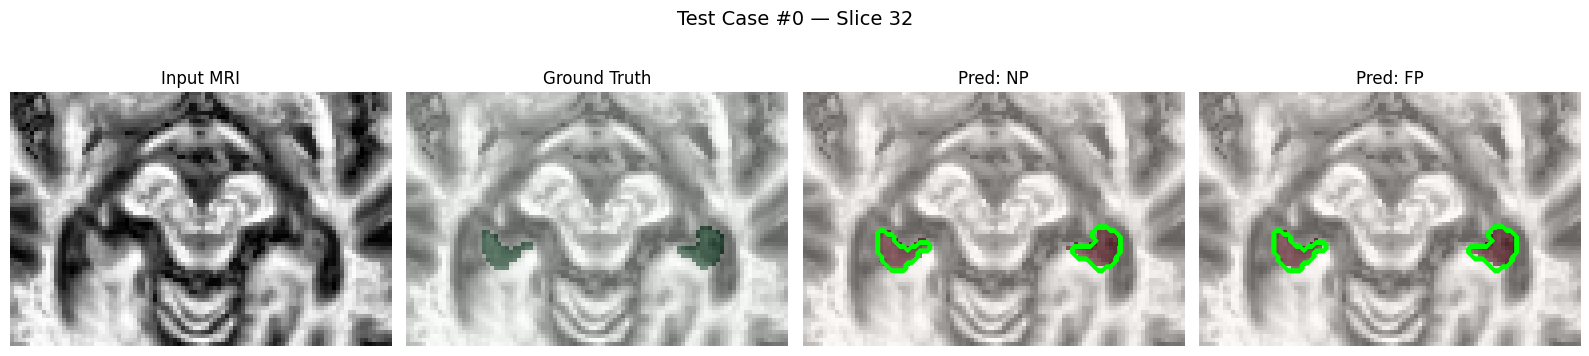

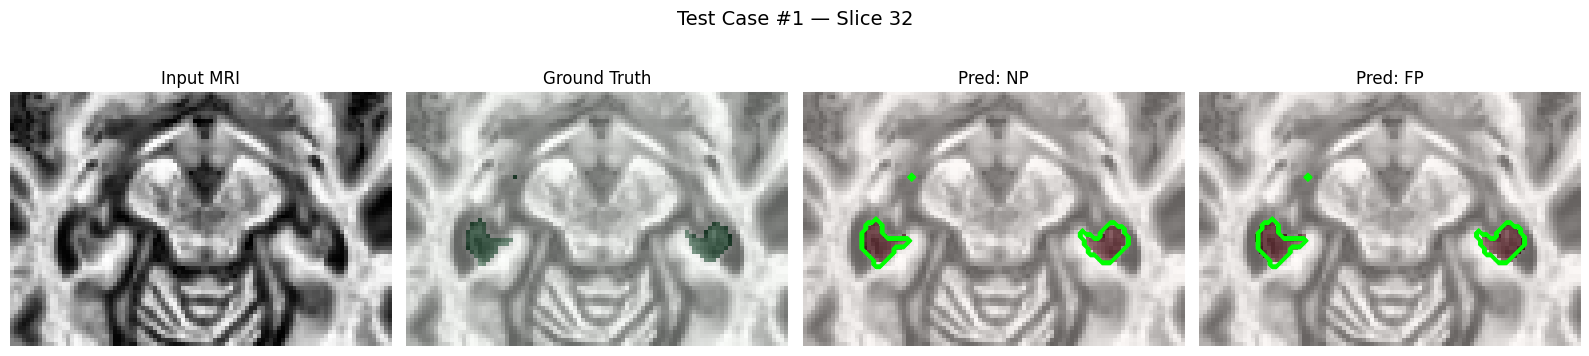

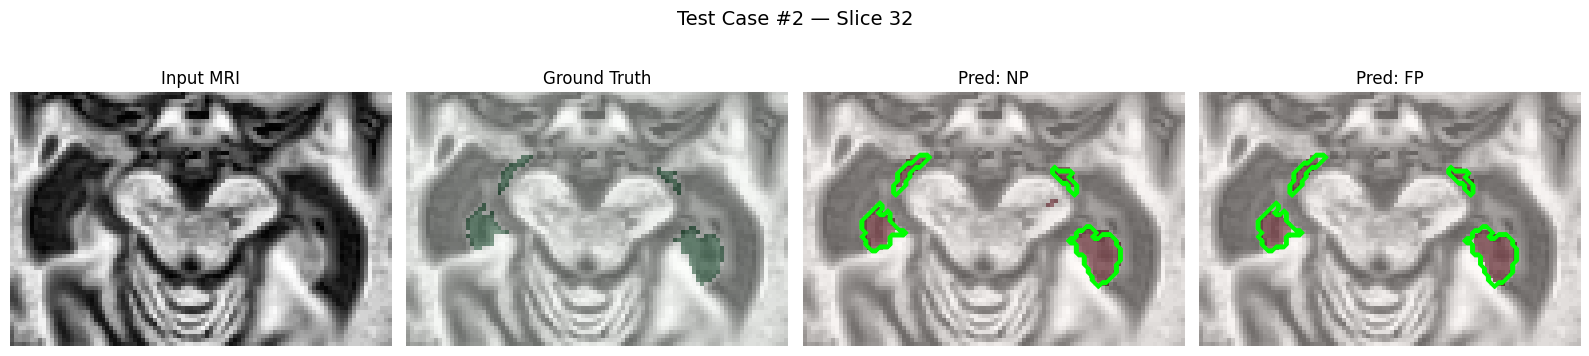

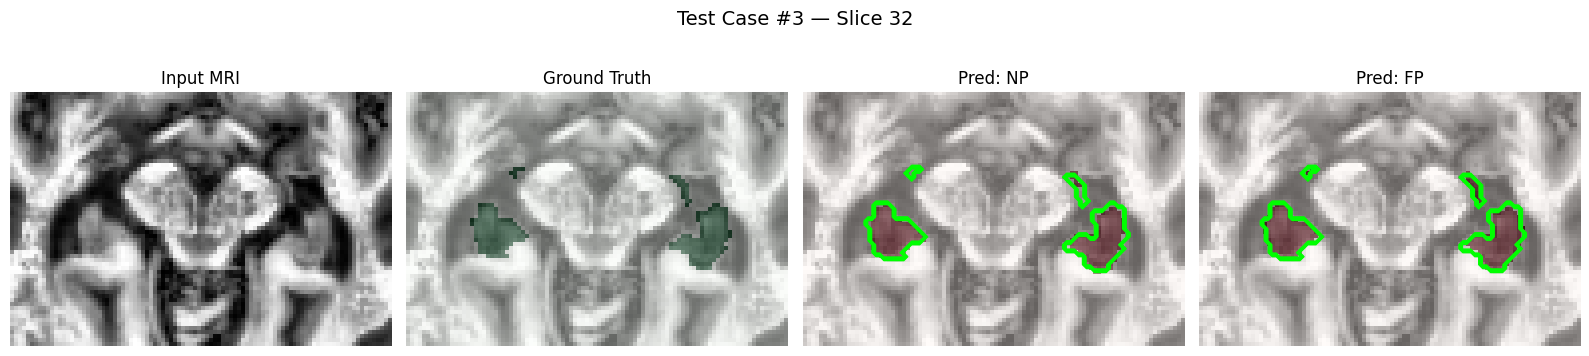

In [102]:
import matplotlib.pyplot as plt

def plot_1x4_overlays(img, gt, preds_dict, method_names, slice_idx, case_idx):
    """
    Plots overlays in a 1-row × 4-col grid:
    1: Input
    2: Ground Truth
    3: NP Prediction
    4: FP Prediction
    """
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    
    # Input MRI
    axs[0].imshow(img[slice_idx], cmap='gray')
    axs[0].set_title("Input MRI")
    axs[0].axis('off')
    
    # Ground Truth
    axs[1].imshow(img[slice_idx], cmap='gray')
    axs[1].imshow(gt[slice_idx], cmap='Greens', alpha=0.4)
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')
    
    # NP Prediction
    axs[2].imshow(img[slice_idx], cmap='gray')
    axs[2].imshow(preds_dict['NP'][slice_idx], cmap='Reds', alpha=0.4)
    axs[2].contour(gt[slice_idx], colors='lime', linewidths=1)
    axs[2].set_title("Pred: NP")
    axs[2].axis('off')
    
    # FP Prediction
    axs[3].imshow(img[slice_idx], cmap='gray')
    axs[3].imshow(preds_dict['FP'][slice_idx], cmap='Reds', alpha=0.4)
    axs[3].contour(gt[slice_idx], colors='lime', linewidths=1)
    axs[3].set_title("Pred: FP")
    axs[3].axis('off')
    
    plt.suptitle(f"Test Case #{case_idx} — Slice {slice_idx}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Use this plotting function in your loop

model_codes = ['NP', 'FP']
model_names = [
    ("NP", "UNet3D_NO_PREPROCESSING"),
    ("FP", "UNet3DdropOutResidualsV2_BCELoss")
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from segmentation import UNet3DDropoutResiduals
models = {}

for code, model_short in model_names:
    model = UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)
    model.load_state_dict(torch.load(f"models/{model_short}.pth", map_location=device))
    model.eval()
    models[code] = model

n_cases = 3
global_case_idx = 0

for case_idx, (img_tensor, gt_tensor) in enumerate(test_loader):
    for b in range(img_tensor.shape[0]):
        img_b = img_tensor[b].cpu().numpy().squeeze()
        gt_b  = gt_tensor[b].cpu().numpy().squeeze()
        preds = {}
        for code in model_codes:
            with torch.no_grad():
                pred = torch.sigmoid(models[code](img_tensor[b:b+1].to(device))).cpu().numpy().squeeze()
                preds[code] = (pred >= 0.5).astype(np.float32)
        D = img_b.shape[0]
        slice_idx = D // 2
        plot_1x4_overlays(img_b, gt_b, preds, model_codes, slice_idx, global_case_idx)
        global_case_idx += 1
    if global_case_idx >= n_cases:
        break


## transfer learning MSD to HARP

#### NP

In [ ]:
model_info = {
    "HARP_NP": {
        "pth": "NewModels/UNet3D_NP_HARP_UPDATED.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\imageTr",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"
    },
    "HARP_FP": {
        "pth": "NewModels/UNet3D_FP_UPDATED.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_Harp_Preprocessed",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"
    },
    "HARP_CLAHE": {
        "pth": "NewModels/UNet3D_3D_CLAHE_UPDATED.pth",
        "img_dir": r"D:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\3DCLAHE_PREPROCESSED",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"
    },
    "MSD_NP": {
        "pth": "NewModels/MSD_NP_BINARY_UPDATED.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\imagesTr",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr"
    },
    "MSD_FP": {
        "pth": "NewModels/MSD_FP_BINARY.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr"
    }
}

In [139]:
### HARP DATASET LOADING AND MSD MODEL
import nibabel as nib
import os
import numpy as np
from sklearn.model_selection import train_test_split

images_dir = r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\imageTr"
labels_dir = r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"

# Function to load a .nii file
def load_nifti_file(filepath):
    img = nib.load(filepath)
    return img.get_fdata()

# List all image and label files
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.nii')])
label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.nii')])

# Verify that corresponding images and labels have the same names
assert len(image_files) == len(label_files)
for img_file, label_file in zip(image_files, label_files):
    assert img_file == label_file, f"Mismatched file: {img_file} and {label_file}"

# Load the data
images = [load_nifti_file(os.path.join(images_dir, f)) for f in image_files]
labels = [load_nifti_file(os.path.join(labels_dir, f)) for f in label_files]

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize image voxel values (between 0 and 1)
images = (images - np.min(images)) / (np.max(images) - np.min(images))

# Check shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


# Split into training, validation, and testing sets (80% train, 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")


Images shape: (135, 64, 64, 96)
Labels shape: (135, 64, 64, 96)
Training set shape: (108, 64, 64, 96)
Validation set shape: (13, 64, 64, 96)
Test set shape: (14, 64, 64, 96)


In [141]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming images and labels are numpy arrays, convert them to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoader objects for training and validation
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Assuming test images and labels are numpy arrays, convert them to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a TensorDataset object for the test set
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create a DataLoader object for the test set
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)  # shuffle=False for test data



In [142]:
import torch.optim as optim  # PyTorch optimizers
from torch.optim import lr_scheduler  # PyTorch learning rate schedulers
import pickle

import torch.optim as optim
from torch.optim import lr_scheduler
# PyTorch optimizer (Adam) and scheduler (ReduceLROnPlateau)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =  UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

model_dir = os.path.join(os.getcwd(), "NewModels")
hist_dir=os.path.join(os.getcwd(), "NewHistory")
os.makedirs(model_dir, exist_ok=True)
os.makedirs(hist_dir, exist_ok=True)

# Initialize history dictionary to store training and validation losses, accuracies, and metrics
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

# --- Load MSD pretrained weights ---
model.load_state_dict(torch.load("NewModels/MSD_NP_BINARY_UPDATED.pth", map_location=device))
print("Loaded MSD_NP_BINARY_UPDATED weights for fine-tuning.")
model_name="Transfer_MSD_NP_to_HARP_NP"

early_stopping_patience=7

epochs_no_improve=0
best_val_loss=10000
num_epochs=250

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_dice': [], 'val_dice': [],
           'train_jaccard': [], 'val_jaccard': [], 'train_f1': [], 'val_f1': [], 'train_iou': [], 'val_iou': [],
           'train_osr': [], 'val_osr': [], 'train_usr': [], 'val_usr': [], 'train_asd': [], 'val_asd': [], 
           'train_hd': [], 'val_hd': []}

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0
    train_correct = 0
    train_dice, train_jaccard, train_f1, train_iou, train_osr, train_usr, train_asd, train_hd = 0, 0, 0, 0, 0, 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()  # PyTorch Adam optimizer has zero_grad()
        outputs = model(X_batch)  # Forward pass
        outputs = torch.sigmoid(outputs)  # Apply sigmoid for binary classification
        loss = bce_loss(y_batch.unsqueeze(1), outputs)  # Compute combined loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        train_loss += loss.item() * X_batch.size(0)

        # Calculate accuracy and metrics
        acc = calculate_accuracy(y_batch.unsqueeze(1), outputs)
        train_correct += acc.item() * X_batch.size(0)
        train_dice += dice_coefficient(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_jaccard += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_f1 += f1_score(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_iou += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)  # IoU (same as Jaccard)
        train_osr += over_segmentation_ratio(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_usr += under_segmentation_rate(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_asd += average_surface_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)
        train_hd += hausdorff_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_dice, val_jaccard, val_f1, val_iou, val_osr, val_usr, val_asd, val_hd = 0, 0, 0, 0, 0, 0, 0, 0

    with torch.no_grad():  # Disable gradient computation for validation
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            outputs = torch.sigmoid(outputs)
            loss = bce_loss(y_batch.unsqueeze(1), outputs)
            val_loss += loss.item() * X_batch.size(0)

            # Calculate accuracy and metrics
            acc = calculate_accuracy(y_batch.unsqueeze(1), outputs)
            val_correct += acc.item() * X_batch.size(0)
            val_dice += dice_coefficient(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_jaccard += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_f1 += f1_score(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_iou += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)  # IoU (same as Jaccard)
            val_osr += over_segmentation_ratio(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_usr += under_segmentation_rate(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_asd += average_surface_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)
            val_hd += hausdorff_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)

    # Step the scheduler with validation loss
    scheduler.step(val_loss / len(val_loader.dataset))

    # Calculate average losses, accuracies, and metrics
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    train_dice /= len(train_loader.dataset)
    val_dice /= len(val_loader.dataset)
    train_jaccard /= len(train_loader.dataset)
    val_jaccard /= len(val_loader.dataset)
    train_f1 /= len(train_loader.dataset)
    val_f1 /= len(val_loader.dataset)
    train_iou /= len(train_loader.dataset)
    val_iou /= len(val_loader.dataset)
    train_osr /= len(train_loader.dataset)
    val_osr /= len(val_loader.dataset)
    train_usr /= len(train_loader.dataset)
    val_usr /= len(val_loader.dataset)
    train_asd /= len(train_loader.dataset)
    val_asd /= len(val_loader.dataset)
    train_hd /= len(train_loader.dataset)
    val_hd /= len(val_loader.dataset)

    # Append the losses, accuracies, and metrics to history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_dice)
    history['train_jaccard'].append(train_jaccard)
    history['val_jaccard'].append(val_jaccard)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)
    history['train_osr'].append(train_osr)
    history['val_osr'].append(val_osr)
    history['train_usr'].append(train_usr)
    history['val_usr'].append(val_usr)
    history['train_asd'].append(train_asd)
    history['val_asd'].append(val_asd)
    history['train_hd'].append(train_hd)
    history['val_hd'].append(val_hd)

    # Print epoch summary
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Dice: {train_dice:.4f}, '
          f'Val Dice: {val_dice:.4f}, Train Jaccard: {train_jaccard:.4f}, Val Jaccard: {val_jaccard:.4f}, '
          f'Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}, '
          f'Train OSR: {train_osr:.4f}, Val OSR: {val_osr:.4f}, Train USR: {train_usr:.4f}, Val USR: {val_usr:.4f}, '
          f'Train ASD: {train_asd:.4f}, Val ASD: {val_asd:.4f}, Train HD: {train_hd:.4f}, Val HD: {val_hd:.4f}')

    # Early Stopping Check
    if val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} -> {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        epochs_no_improve = 0  
        weights_path = os.path.join(model_dir, f"{model_name}.pth")
        torch.save(model.state_dict(), weights_path)
        print(f"Saved weights to '{weights_path}'")

    else:
        epochs_no_improve += 1
        print(f'No improvement in validation loss for {epochs_no_improve} epochs.')

    # If the validation loss doesn't improve for `early_stopping_patience` epochs, stop the training
    if epochs_no_improve == early_stopping_patience:
        print(f'Early stopping triggered. No improvement in validation loss for {early_stopping_patience} consecutive epochs.')
        break  # Exit the training loop


history_path = os.path.join(hist_dir, f"{model_name}_training_history.pkl")
with open(history_path, "wb") as f:
    pickle.dump(history, f)
print(f"Training history saved to '{history_path}'.")


Training on device: cuda
Loaded MSD_NP_BINARY_UPDATED weights for fine-tuning.


C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:66: DeprecationWarning: Please import `generate_binary_structure` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  conn = morphology.generate_binary_structure(y_true_np.ndim, 1)
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:69: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  true_surface = np.logical_xor(y_true_np, morphology.binary_erosion(y_true_np, conn))
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:70: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  pred_surface = np.logical_xor(y_pred_np, morphology.binary_erosion(y_pred_np, conn))
C:\Use

Epoch 1/250, Train Loss: 0.0249, Val Loss: 0.0167, Train Acc: 0.9920, Val Acc: 0.9939, Train Dice: 0.6740, Val Dice: 0.7727, Train Jaccard: 0.5310, Val Jaccard: 0.6353, Train F1: 0.8211, Val F1: 0.8641, Train IoU: 0.5310, Val IoU: 0.6353, Train OSR: 0.1080, Val OSR: 0.1074, Train USR: 0.2180, Val USR: 0.1199, Train ASD: 7.9059, Val ASD: 7.9217, Train HD: 11.4337, Val HD: 7.0056
Validation loss improved (10000.0000 -> 0.0167). Saving model...
Saved weights to 'd:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\NewModels\Transfer_MSD_NP_to_HARP_NP.pth'
Epoch 2/250, Train Loss: 0.0158, Val Loss: 0.0146, Train Acc: 0.9944, Val Acc: 0.9947, Train Dice: 0.7938, Val Dice: 0.8030, Train Jaccard: 0.6607, Val Jaccard: 0.6771, Train F1: 0.8740, Val F1: 0.8807, Train IoU: 0.6607, Val IoU: 0.6771, Train OSR: 0.0946, Val OSR: 0.0874, Train USR: 0.1117, Val USR: 0.1096, Train ASD: 7.8890, Val ASD: 7.9217, Train HD: 7.1979, Val HD: 6.1550
Validation loss improved (0.0167 -> 0.0146). Saving model..

In [143]:
# TEsting MSD to HARP NP
import os
import pickle
import torch
import pandas as pd


# 2) Paths and names
model_name="Transfer_MSD_NP_to_HARP_NP"
model_dir = os.path.join(os.getcwd(), "NewModels")
hist_dir=os.path.join(os.getcwd(), "NewHistory")


weights_path = os.path.join(model_dir, f"{model_name}.pth")
history_path = os.path.join(hist_dir, f"{model_name}_training_history.pkl")

# 3) Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 4) Load the model
model = UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

# 5) Load training history
with open(history_path, "rb") as f:
    history = pickle.load(f)

# 6) Evaluate on test set
test_loss = test_acc = test_dice = test_jaccard = test_f1 = test_iou = test_osr = test_usr = test_asd = test_hd = 0.0
n_samples = len(test_loader.dataset)

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = torch.sigmoid(model(X_batch))
        
        bs = X_batch.size(0)
        test_loss    += bce_loss(y_batch.unsqueeze(1), outputs).item() * bs
        test_acc     += calculate_accuracy(y_batch.unsqueeze(1), outputs).item() * bs
        test_dice    += dice_coefficient(y_batch.unsqueeze(1), outputs).item() * bs
        test_jaccard += jaccard_index(y_batch.unsqueeze(1), outputs).item() * bs
        test_f1      += f1_score(y_batch.unsqueeze(1), outputs).item() * bs
        test_iou     += jaccard_index(y_batch.unsqueeze(1), outputs).item() * bs
        test_osr     += over_segmentation_ratio(y_batch.unsqueeze(1), outputs).item() * bs
        test_usr     += under_segmentation_rate(y_batch.unsqueeze(1), outputs).item() * bs
        test_asd     += average_surface_distance(y_batch.unsqueeze(1), outputs) * bs
        test_hd      += hausdorff_distance(y_batch.unsqueeze(1), outputs) * bs

# 7) Compute averages
test_metrics = {
    'loss':    test_loss    / n_samples,
    'acc':     test_acc     / n_samples,
    'dice':    test_dice    / n_samples,
    'jaccard': test_jaccard / n_samples,
    'f1':      test_f1      / n_samples,
    'iou':     test_iou     / n_samples,
    'osr':     test_osr     / n_samples,
    'usr':     test_usr     / n_samples,
    'asd':     test_asd     / n_samples,
    'hd':      test_hd      / n_samples,
}

# 8) Build and print the final table
metrics = ['loss','acc','dice','jaccard','f1','iou','osr','usr','asd','hd']
train_vals = [history[f'train_{m}'][-1] for m in metrics]
val_vals   = [history[f'val_{m}'][-1]   for m in metrics]
test_vals  = [test_metrics[m]            for m in metrics]

df = pd.DataFrame({
    'Train': train_vals,
    'Val':   val_vals,
    'Test':  test_vals
}, index=metrics)

print("\n=== Final Metrics (Train / Val / Test) For model Transfer_MSD_NP_to_HARP_NP===")
print(df.to_string(float_format="%.4f"))


Using device: cuda


C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:66: DeprecationWarning: Please import `generate_binary_structure` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  conn = morphology.generate_binary_structure(y_true_np.ndim, 1)
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:69: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  true_surface = np.logical_xor(y_true_np, morphology.binary_erosion(y_true_np, conn))
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:70: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  pred_surface = np.logical_xor(y_pred_np, morphology.binary_erosion(y_pred_np, conn))
C:\Use


=== Final Metrics (Train / Val / Test) For model Transfer_MSD_NP_to_HARP_NP===
         Train    Val   Test
loss    0.0097 0.0122 0.0075
acc     0.9963 0.9956 0.9969
dice    0.8668 0.8430 0.8843
jaccard 0.7671 0.7371 0.7928
f1      0.9160 0.9039 0.9260
iou     0.7671 0.7371 0.7928
osr     0.0654 0.0877 0.0638
usr     0.0678 0.0694 0.0519
asd     7.8790 7.9217 8.0823
hd      4.0188 3.7332 3.3142


#### FP

In [151]:
### HARP DATASET LOADING AND MSD MODEL
import nibabel as nib
import os
import numpy as np
from sklearn.model_selection import train_test_split

images_dir = r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_Harp_Preprocessed"
labels_dir = r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"

# Function to load a .nii file
def load_nifti_file(filepath):
    img = nib.load(filepath)
    return img.get_fdata()

# List all image and label files
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.nii')])
label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.nii')])

# Verify that corresponding images and labels have the same names
assert len(image_files) == len(label_files)
for img_file, label_file in zip(image_files, label_files):
    assert img_file == label_file, f"Mismatched file: {img_file} and {label_file}"

# Load the data
images = [load_nifti_file(os.path.join(images_dir, f)) for f in image_files]
labels = [load_nifti_file(os.path.join(labels_dir, f)) for f in label_files]

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize image voxel values (between 0 and 1)
images = (images - np.min(images)) / (np.max(images) - np.min(images))

# Check shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


# Split into training, validation, and testing sets (80% train, 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

import torch
from torch.utils.data import DataLoader, TensorDataset
# Assuming images and labels are numpy arrays, convert them to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
# Create TensorDataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
# Create DataLoader objects for training and validation
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
# Assuming test images and labels are numpy arrays, convert them to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
# Create a TensorDataset object for the test set
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Create a DataLoader object for the test set
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)  # shuffle=False for test data



Images shape: (135, 64, 64, 96)
Labels shape: (135, 64, 64, 96)
Training set shape: (108, 64, 64, 96)
Validation set shape: (13, 64, 64, 96)
Test set shape: (14, 64, 64, 96)


In [152]:
### training msd on harp FP
import torch.optim as optim  # PyTorch optimizers
from torch.optim import lr_scheduler  # PyTorch learning rate schedulers
import pickle

import torch.optim as optim
from torch.optim import lr_scheduler
# PyTorch optimizer (Adam) and scheduler (ReduceLROnPlateau)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =  UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

model_dir = os.path.join(os.getcwd(), "NewModels")
hist_dir=os.path.join(os.getcwd(), "NewHistory")
os.makedirs(model_dir, exist_ok=True)
os.makedirs(hist_dir, exist_ok=True)

# Initialize history dictionary to store training and validation losses, accuracies, and metrics
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

# --- Load MSD pretrained weights ---
model.load_state_dict(torch.load("NewModels/MSD_FP_BINARY.pth", map_location=device))
print("Loaded MSD_FP_BINARY weights for fine-tuning.")
model_name="Transfer_MSD_FP_to_HARP_FP"

early_stopping_patience=7

epochs_no_improve=0
best_val_loss=10000
num_epochs=250

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_dice': [], 'val_dice': [],
           'train_jaccard': [], 'val_jaccard': [], 'train_f1': [], 'val_f1': [], 'train_iou': [], 'val_iou': [],
           'train_osr': [], 'val_osr': [], 'train_usr': [], 'val_usr': [], 'train_asd': [], 'val_asd': [], 
           'train_hd': [], 'val_hd': []}

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0
    train_correct = 0
    train_dice, train_jaccard, train_f1, train_iou, train_osr, train_usr, train_asd, train_hd = 0, 0, 0, 0, 0, 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()  # PyTorch Adam optimizer has zero_grad()
        outputs = model(X_batch)  # Forward pass
        outputs = torch.sigmoid(outputs)  # Apply sigmoid for binary classification
        loss = bce_loss(y_batch.unsqueeze(1), outputs)  # Compute combined loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        train_loss += loss.item() * X_batch.size(0)

        # Calculate accuracy and metrics
        acc = calculate_accuracy(y_batch.unsqueeze(1), outputs)
        train_correct += acc.item() * X_batch.size(0)
        train_dice += dice_coefficient(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_jaccard += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_f1 += f1_score(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_iou += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)  # IoU (same as Jaccard)
        train_osr += over_segmentation_ratio(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_usr += under_segmentation_rate(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
        train_asd += average_surface_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)
        train_hd += hausdorff_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_dice, val_jaccard, val_f1, val_iou, val_osr, val_usr, val_asd, val_hd = 0, 0, 0, 0, 0, 0, 0, 0

    with torch.no_grad():  # Disable gradient computation for validation
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            outputs = torch.sigmoid(outputs)
            loss = bce_loss(y_batch.unsqueeze(1), outputs)
            val_loss += loss.item() * X_batch.size(0)

            # Calculate accuracy and metrics
            acc = calculate_accuracy(y_batch.unsqueeze(1), outputs)
            val_correct += acc.item() * X_batch.size(0)
            val_dice += dice_coefficient(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_jaccard += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_f1 += f1_score(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_iou += jaccard_index(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)  # IoU (same as Jaccard)
            val_osr += over_segmentation_ratio(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_usr += under_segmentation_rate(y_batch.unsqueeze(1), outputs).item() * X_batch.size(0)
            val_asd += average_surface_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)
            val_hd += hausdorff_distance(y_batch.unsqueeze(1), outputs) * X_batch.size(0)

    # Step the scheduler with validation loss
    scheduler.step(val_loss / len(val_loader.dataset))

    # Calculate average losses, accuracies, and metrics
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    train_dice /= len(train_loader.dataset)
    val_dice /= len(val_loader.dataset)
    train_jaccard /= len(train_loader.dataset)
    val_jaccard /= len(val_loader.dataset)
    train_f1 /= len(train_loader.dataset)
    val_f1 /= len(val_loader.dataset)
    train_iou /= len(train_loader.dataset)
    val_iou /= len(val_loader.dataset)
    train_osr /= len(train_loader.dataset)
    val_osr /= len(val_loader.dataset)
    train_usr /= len(train_loader.dataset)
    val_usr /= len(val_loader.dataset)
    train_asd /= len(train_loader.dataset)
    val_asd /= len(val_loader.dataset)
    train_hd /= len(train_loader.dataset)
    val_hd /= len(val_loader.dataset)

    # Append the losses, accuracies, and metrics to history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_dice)
    history['train_jaccard'].append(train_jaccard)
    history['val_jaccard'].append(val_jaccard)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)
    history['train_osr'].append(train_osr)
    history['val_osr'].append(val_osr)
    history['train_usr'].append(train_usr)
    history['val_usr'].append(val_usr)
    history['train_asd'].append(train_asd)
    history['val_asd'].append(val_asd)
    history['train_hd'].append(train_hd)
    history['val_hd'].append(val_hd)

    # Print epoch summary
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Dice: {train_dice:.4f}, '
          f'Val Dice: {val_dice:.4f}, Train Jaccard: {train_jaccard:.4f}, Val Jaccard: {val_jaccard:.4f}, '
          f'Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}, '
          f'Train OSR: {train_osr:.4f}, Val OSR: {val_osr:.4f}, Train USR: {train_usr:.4f}, Val USR: {val_usr:.4f}, '
          f'Train ASD: {train_asd:.4f}, Val ASD: {val_asd:.4f}, Train HD: {train_hd:.4f}, Val HD: {val_hd:.4f}')

    # Early Stopping Check
    if val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} -> {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        epochs_no_improve = 0  
        weights_path = os.path.join(model_dir, f"{model_name}.pth")
        torch.save(model.state_dict(), weights_path)
        print(f"Saved weights to '{weights_path}'")

    else:
        epochs_no_improve += 1
        print(f'No improvement in validation loss for {epochs_no_improve} epochs.')

    # If the validation loss doesn't improve for `early_stopping_patience` epochs, stop the training
    if epochs_no_improve == early_stopping_patience:
        print(f'Early stopping triggered. No improvement in validation loss for {early_stopping_patience} consecutive epochs.')
        break  # Exit the training loop


history_path = os.path.join(hist_dir, f"{model_name}_training_history.pkl")
with open(history_path, "wb") as f:
    pickle.dump(history, f)
print(f"Training history saved to '{history_path}'.")


Training on device: cuda
Loaded MSD_FP_BINARY weights for fine-tuning.


C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:66: DeprecationWarning: Please import `generate_binary_structure` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  conn = morphology.generate_binary_structure(y_true_np.ndim, 1)
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:69: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  true_surface = np.logical_xor(y_true_np, morphology.binary_erosion(y_true_np, conn))
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:70: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  pred_surface = np.logical_xor(y_pred_np, morphology.binary_erosion(y_pred_np, conn))
C:\Use

Epoch 1/250, Train Loss: 0.0280, Val Loss: 0.0187, Train Acc: 0.9909, Val Acc: 0.9929, Train Dice: 0.6339, Val Dice: 0.7403, Train Jaccard: 0.4808, Val Jaccard: 0.5928, Train F1: 0.8056, Val F1: 0.8470, Train IoU: 0.4808, Val IoU: 0.5928, Train OSR: 0.1288, Val OSR: 0.1238, Train USR: 0.2374, Val USR: 0.1359, Train ASD: 7.9239, Val ASD: 7.9217, Train HD: 10.6783, Val HD: 5.3824
Validation loss improved (10000.0000 -> 0.0187). Saving model...
Saved weights to 'd:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\NewModels\Transfer_MSD_FP_to_HARP_FP.pth'
Epoch 2/250, Train Loss: 0.0179, Val Loss: 0.0170, Train Acc: 0.9935, Val Acc: 0.9936, Train Dice: 0.7612, Val Dice: 0.7585, Train Jaccard: 0.6167, Val Jaccard: 0.6163, Train F1: 0.8562, Val F1: 0.8564, Train IoU: 0.6167, Val IoU: 0.6163, Train OSR: 0.1029, Val OSR: 0.0986, Train USR: 0.1360, Val USR: 0.1430, Train ASD: 7.8981, Val ASD: 7.9217, Train HD: 6.5003, Val HD: 5.5754
Validation loss improved (0.0187 -> 0.0170). Saving model..

In [153]:
# TEsting MSD to HARP FP
import os
import pickle
import torch
import pandas as pd


# 2) Paths and names
model_name="Transfer_MSD_FP_to_HARP_FP"
model_dir = os.path.join(os.getcwd(), "NewModels")
hist_dir=os.path.join(os.getcwd(), "NewHistory")


weights_path = os.path.join(model_dir, f"{model_name}.pth")
history_path = os.path.join(hist_dir, f"{model_name}_training_history.pkl")

# 3) Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 4) Load the model
model = UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

# 5) Load training history
with open(history_path, "rb") as f:
    history = pickle.load(f)

# 6) Evaluate on test set
test_loss = test_acc = test_dice = test_jaccard = test_f1 = test_iou = test_osr = test_usr = test_asd = test_hd = 0.0
n_samples = len(test_loader.dataset)

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = torch.sigmoid(model(X_batch))
        
        bs = X_batch.size(0)
        test_loss    += bce_loss(y_batch.unsqueeze(1), outputs).item() * bs
        test_acc     += calculate_accuracy(y_batch.unsqueeze(1), outputs).item() * bs
        test_dice    += dice_coefficient(y_batch.unsqueeze(1), outputs).item() * bs
        test_jaccard += jaccard_index(y_batch.unsqueeze(1), outputs).item() * bs
        test_f1      += f1_score(y_batch.unsqueeze(1), outputs).item() * bs
        test_iou     += jaccard_index(y_batch.unsqueeze(1), outputs).item() * bs
        test_osr     += over_segmentation_ratio(y_batch.unsqueeze(1), outputs).item() * bs
        test_usr     += under_segmentation_rate(y_batch.unsqueeze(1), outputs).item() * bs
        test_asd     += average_surface_distance(y_batch.unsqueeze(1), outputs) * bs
        test_hd      += hausdorff_distance(y_batch.unsqueeze(1), outputs) * bs

# 7) Compute averages
test_metrics = {
    'loss':    test_loss    / n_samples,
    'acc':     test_acc     / n_samples,
    'dice':    test_dice    / n_samples,
    'jaccard': test_jaccard / n_samples,
    'f1':      test_f1      / n_samples,
    'iou':     test_iou     / n_samples,
    'osr':     test_osr     / n_samples,
    'usr':     test_usr     / n_samples,
    'asd':     test_asd     / n_samples,
    'hd':      test_hd      / n_samples,
}

# 8) Build and print the final table
metrics = ['loss','acc','dice','jaccard','f1','iou','osr','usr','asd','hd']
train_vals = [history[f'train_{m}'][-1] for m in metrics]
val_vals   = [history[f'val_{m}'][-1]   for m in metrics]
test_vals  = [test_metrics[m]            for m in metrics]

df = pd.DataFrame({
    'Train': train_vals,
    'Val':   val_vals,
    'Test':  test_vals
}, index=metrics)

print("\n=== Final Metrics (Train / Val / Test) For model Transfer_MSD_NP_to_HARP_NP===")
print(df.to_string(float_format="%.4f"))


Using device: cuda


C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:66: DeprecationWarning: Please import `generate_binary_structure` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  conn = morphology.generate_binary_structure(y_true_np.ndim, 1)
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:69: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  true_surface = np.logical_xor(y_true_np, morphology.binary_erosion(y_true_np, conn))
C:\Users\Faizaan\AppData\Local\Temp\ipykernel_18392\2639920175.py:70: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  pred_surface = np.logical_xor(y_pred_np, morphology.binary_erosion(y_pred_np, conn))
C:\Use


=== Final Metrics (Train / Val / Test) For model Transfer_MSD_NP_to_HARP_NP===
         Train    Val   Test
loss    0.0103 0.0125 0.0083
acc     0.9961 0.9955 0.9966
dice    0.8608 0.8355 0.8736
jaccard 0.7574 0.7260 0.7757
f1      0.9124 0.8997 0.9196
iou     0.7574 0.7260 0.7757
osr     0.0701 0.0886 0.0705
usr     0.0691 0.0760 0.0560
asd     7.9017 7.9217 8.0823
hd      3.5072 3.8361 3.1919
